## Pseudo-código Classifier

### 1° passo: recebe uma "internal workorder" que específica a quantidade, cor, tamanho, sabor e embalagem a ser produzido

In [1]:
import pandas as pd
import math
import numpy as np
import simpy
import seaborn as sns
import matplotlib.pyplot as plt
import time
%matplotlib inline

start = time.time()

## Ler os dados fornecidos

In [2]:
RMI = pd.read_csv('D:/Programas/UFSC/2020_OR_Analytics_Student_Team_Competition/Reuniões/2020/27_01/'+'RMI_PMP.csv')
RMI.drop(columns='Unnamed: 0',inplace=True)
RMI.to_excel('RMI.xlsx')

In [3]:
path = 'D:/Programas/UFSC/2020_OR_Analytics_Student_Team_Competition/1. Base de Dados do Problema/Original/'

#Notebook Vitor: 'D:/Programas/UFSC/2020_OR_Analytics_Student_Team_Competition/Base de Dados do Problema/Original/'
#Notebook Luccas: 'C:/Users/lucca/Desktop/OR & Analytics 2020/Dados/'

#IMPORTANDO E TRATANDO OS DADOS

workorder = pd.read_excel('D:/Programas/UFSC/2020_OR_Analytics_Student_Team_Competition/Reuniões/2020/27_01/Pasta sem nome/pmp_real_Green Bay.xlsx')
#workorder['Color'] = workorder['Color'].str.title()
#workorder['Plant Id'] = workorder['Plant Id'].replace({'COLUMBUSOH': 'Columbus, OH', 'DETROITMI': 'Detroit, MI', 'SPRINGFIELDMO': 'Springfield, MO', 'GREENBAYWE': 'Green Bay, WE', 'OMAHANE': 'Omaha, NE'}, regex = True)
workorder['Stage'] = 0
workorder['Produzido'] = ''
workorder['Inicio'] = 0
workorder['Fim'] = 0
#
RMI = pd.read_csv('D:/Programas/UFSC/2020_OR_Analytics_Student_Team_Competition/Reuniões/2020/27_01/'+'RMI_PMP.csv')
RMI['num'] = RMI['RMI Drum'].apply(lambda x: int(x.split(sep='RMI DRUM')[-1])-1)
#
classifier_rates= pd.read_csv(path+'Classifier.csv')
classifier_rates['Site'] = classifier_rates['Site'].replace({'Columbus': 'Columbus, OH', 'Detroit': 'Detroit, MI', 'Springfield': 'Springfield, MO', 'Green Bay': 'Green Bay, WI', 'Omaha': 'Omaha, NE'}, regex = True)
#
split = pd.read_csv(path+'Classifier Split.csv')
#
pfi_drum= pd.read_csv(path+'Pre-finish Inventory Drum.csv')
#
PFI = pd.read_csv(path+'Pre-finish.csv')
PFI['Site']=PFI['Site'].replace({'Columbus': 'Columbus, OH', 'Detroit': 'Detroit, MI', 'Springfield': 'Springfield, MO', 'Green Bay': 'Green Bay, WI', 'Omaha': 'Omaha, NE'}, regex = True)
#
equipment = pd.read_excel(path+'Arquivos PDF/Amount of equipment and drums.xlsx', nrows = 5, index_col = 'Manufacturing Facility')
equipment['Bag Machines'] = equipment['Number of Packaging Machines'].apply(lambda x: int(x.split(' ')[0]))
equipment['Box Machines'] = equipment['Number of Packaging Machines'].apply(lambda x: int(x.split(' ')[2]))
equipment.drop(columns='Number of Packaging Machines', inplace = True)
#
pi_drum = pd.read_csv(path+'Pack inventory Drum.csv')
#
pounds = pd.read_csv(path+'Pound to bag and pound to box.csv', names = ['Pounds', 'Type'], index_col = 'Type')
pounds.rename(index={'lb/bag': "Bag",'lb/box': "Box",}, inplace = True)
#
packaging = pd.read_csv(path+'Packaging.csv')
packaging['Site']= packaging['Site'].replace({'Columbus': 'Columbus, OH', 'Detroit': 'Detroit, MI', 'Springfield': 'Springfield, MO', 'Green Bay': 'Green Bay, WI', 'Omaha': 'Omaha, NE'}, regex = True)
#
#DEFINE A FÁBRICA DA SIMULAÇÃO
factory = workorder['Plant Id'][1]

PFI['Processing_Rate'] = PFI['Processing_Rate'].abs()
packaging['Processing_Rate'] = packaging['Processing_Rate'].abs()

custos = pd.read_csv(path + 'Custos.csv',sep = ';')
custos['Manufacturing cost by site'] = custos['Manufacturing cost by site'].replace({'Columbus': 'Columbus, OH', 'Detroit': 'Detroit, MI', 'Springfield': 'Springfield, MO', 'Green Bay': 'Green Bay, WI', 'Omaha': 'Omaha, NE'}, regex = True)

# PMP

## Análise dos dados fornecidos

In [4]:
workorder = workorder.round({'Qty': 0})
workorder.head(10)

,Plant Id,Internal Work Order Id,Color,Size,Flavor,Packaging Type,Qty,Stage,Produzido,Inicio,Fim
0,"Green Bay, WI",GBW234882,Coloring Agent23,S1,F12,Bag,6680.0,0,,0,0
1,"Green Bay, WI",GBW234882,Coloring Agent23,S2,F1,Bag,3855.0,0,,0,0
2,"Green Bay, WI",GBW234882,Coloring Agent23,S2,F10,Bag,2101.0,0,,0,0
3,"Green Bay, WI",GBW234882,Coloring Agent23,S2,F11,Bag,2729.0,0,,0,0
4,"Green Bay, WI",GBW234882,Coloring Agent23,S2,F2,Bag,2432.0,0,,0,0
5,"Green Bay, WI",GBW234882,Coloring Agent23,S2,F3,Box,2880.0,0,,0,0
6,"Green Bay, WI",GBW234882,Coloring Agent23,S3,F1,Box,2878.0,0,,0,0
7,"Green Bay, WI",GBW234882,Coloring Agent23,S3,F10,Bag,2416.0,0,,0,0
8,"Green Bay, WI",GBW234882,Coloring Agent23,S3,F11,Bag,3665.0,0,,0,0
9,"Green Bay, WI",GBW234882,Coloring Agent23,S3,F3,Bag,3063.0,0,,0,0


### 2° passo: Com base na workorder recebida, vá até o RMI e pegue a quantidade "necessária" para atender o pedido. Se houver dois tambores RMI da mesma cor em um determinado local, esvazie o tambor com um número menor de equipamento.

In [5]:
RMI.drop(columns='Unnamed: 0',inplace=True)
RMI[(RMI['Location Name'] == factory)].head()

,Location Name,RMI Drum,Color,Qty in pounds,Capacity,num
120,"Green Bay, WI",RMI DRUM1,Coloring Agent25,73351.038,"330,000",0
121,"Green Bay, WI",RMI DRUM2,Coloring Agent12,93912.570,"330,000",1
122,"Green Bay, WI",RMI DRUM3,Coloring Agent36,109178.738,"330,000",2
123,"Green Bay, WI",RMI DRUM4,Coloring Agent18,112444.586,"330,000",3
124,"Green Bay, WI",RMI DRUM5,Coloring Agent3,156454.166,"330,000",4


#### Ao atender a workorder especificada, verifica-se que há apenas 1 drum com a cor selecionada

In [6]:
split.head()

,Color,Size,Percentage
0,Coloring Agent1,S1,12
1,Coloring Agent1,S5,27
2,Coloring Agent1,S4,19
3,Coloring Agent1,S2,29
4,Coloring Agent1,S3,13


In [7]:
Color = workorder['Color'][1] #Define a cor para obter os % dos splits
split[(split['Color ']==Color)].sort_values(by=['Size'])

,Color,Size,Percentage
114,Coloring Agent23,S1,12
110,Coloring Agent23,S2,26
113,Coloring Agent23,S3,23
111,Coloring Agent23,S4,17
112,Coloring Agent23,S5,22


### 3° passo: Processar os valores especificados no classificador e preencher os PFI Drums

In [8]:
classifier_rates

,Site,Classifier,Processing_Rate
0,"Detroit, MI",Classifier 1,3420
1,"Columbus, OH",Classifier 2,2280
2,"Green Bay, WI",Classifier 3,2050
3,"Springfield, MO",Classifier 4,1260
4,"Omaha, NE",Classifier 5,4440


In [9]:
pfi_drum[pfi_drum['Site']==factory].head()

,Site,Drum Number,Capacity In pounds
71,"Green Bay, WI",PFI Drum1,"6,500"
72,"Green Bay, WI",PFI Drum2,"6,500"
73,"Green Bay, WI",PFI Drum3,"6,500"
74,"Green Bay, WI",PFI Drum4,"6,500"
75,"Green Bay, WI",PFI Drum5,"6,500"


## Pre-Finish

In [10]:
PFI[PFI['Site']==factory].head()

,Site,Size,Flavor,Processing_Rate
120000,"Green Bay, WI",S1,F1,866
120001,"Green Bay, WI",S1,F1,862
120002,"Green Bay, WI",S1,F1,675
120003,"Green Bay, WI",S1,F1,829
120004,"Green Bay, WI",S1,F1,845


In [11]:
PFI['Site'].unique()

array(['Detroit, MI', 'Columbus, OH', 'Green Bay, WI', 'Springfield, MO',
       'Omaha, NE'], dtype=object)

Média de 850.5113
Desvio padrão de 120.35375228635296


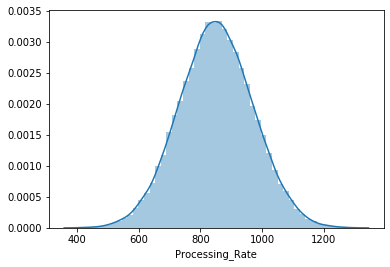

In [12]:
teste = PFI[(PFI['Site']==factory)]['Processing_Rate']
#Filtro o DataFrame

sns.distplot(teste)
print(f'Média de {teste.mean()}')
print(f'Desvio padrão de {teste.std()}')

In [13]:
equipment
#Temos 3 Equipamentos

,Number of RMI Drums,Number of PF Drums,Number of Pre-finish operation equipment,Number of PI Drums,Bag Machines,Box Machines
Manufacturing Facility,,,,,,
"Detroit, MI",40,15,2,8,1,1
"Columbus, OH",30,32,3,10,2,1
"Springfield, MO",50,24,1,15,1,1
"Green Bay, WI",20,17,2,17,1,1
"Omaha, NE",30,28,3,12,1,1


In [14]:
pi_drum[pi_drum['Site']==factory]

,Site,Drum Number,Capacity
33,"Green Bay, WI",FI Drum 1,"5,500"
34,"Green Bay, WI",FI Drum 2,"5,500"
35,"Green Bay, WI",FI Drum 3,"5,500"
36,"Green Bay, WI",FI Drum 4,"5,500"
37,"Green Bay, WI",FI Drum 5,"5,500"
38,"Green Bay, WI",FI Drum 6,"5,500"
39,"Green Bay, WI",FI Drum 7,"5,500"
40,"Green Bay, WI",FI Drum 8,"5,500"
41,"Green Bay, WI",FI Drum 9,"5,500"
42,"Green Bay, WI",FI Drum 10,"5,500"


## Packaging

In [15]:
#Temos 2 Bags e 1 Box
#Box line tem prefência sobre Bag (SimPY)
equipment

,Number of RMI Drums,Number of PF Drums,Number of Pre-finish operation equipment,Number of PI Drums,Bag Machines,Box Machines
Manufacturing Facility,,,,,,
"Detroit, MI",40,15,2,8,1,1
"Columbus, OH",30,32,3,10,2,1
"Springfield, MO",50,24,1,15,1,1
"Green Bay, WI",20,17,2,17,1,1
"Omaha, NE",30,28,3,12,1,1


Média de 1589.7858
Desvio padrão de 197.1124516160163


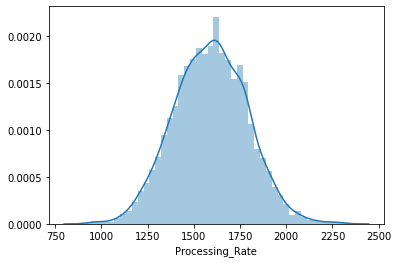

In [16]:
tipo = 'Bag' # 'Box'
teste2= packaging[(packaging['Site']==factory) & (packaging['Packaging_Type']==tipo)]['Processing_Rate']
#Filtro o DataFrame

sns.distplot(teste2)
print(f'Média de {teste2.mean()}')
print(f'Desvio padrão de {teste2.std()}')

In [17]:
pounds

,Pounds
Type,
Bag,0.25
Box,2.50


### Cria o DataFrame Auxiliar

In [18]:
# AUTOMATIZAR A DECLARAÇÃO DE PFI EQUIPMENTS PARA CADA FABRICA

machines = equipment[equipment.index==factory]['Number of Pre-finish operation equipment'][0]
pfi_names = []
for i in range(machines):
    pfi_names.append('PFI_'+str(i+1))

pfi_eq_aux = pd.DataFrame({'PFI': pfi_names, 'Sabor': "",'Ocupado':0 ,'Num':np.arange(machines), 'Ultimo_uso':0})
pfi_eq_aux.set_index('PFI',inplace=True)
pfi_eq_aux

,Sabor,Ocupado,Num,Ultimo_uso
PFI,,,,
PFI_1,,0,0,0
PFI_2,,0,1,0


In [19]:
pfi_drum_aux = pfi_drum[pfi_drum['Site']==factory].replace({'Drum Number': " ", 'Capacity In pounds':','},{'Drum Number': "_", 'Capacity In pounds':''},regex=True).drop(['Site'],axis=1).astype({'Capacity In pounds': 'int32'})
pfi_drum_aux['Level'] = 0
pfi_drum_aux['Cor'] = ''
pfi_drum_aux['Size'] = ''
pfi_drum_aux['Num'] = pfi_drum_aux['Drum Number'].apply(lambda x: int(x.split('PFI_Drum')[-1])-1)
pfi_drum_aux.set_index('Drum Number',inplace=True)
pfi_drum_aux.head()

,Capacity In pounds,Level,Cor,Size,Num
Drum Number,,,,,
PFI_Drum1,6500,0,,,0
PFI_Drum2,6500,0,,,1
PFI_Drum3,6500,0,,,2
PFI_Drum4,6500,0,,,3
PFI_Drum5,6500,0,,,4


In [20]:
fi_drum_aux = pi_drum[pi_drum['Site']==factory].replace({'Drum Number': ' ', 'Capacity':','}, {'Drum Number': '_', 'Capacity':''}, regex = True).astype({'Capacity': 'int32'})
fi_drum_aux['Level'] = 0
fi_drum_aux['Cor'] = ''
fi_drum_aux['Size'] = ''
fi_drum_aux['Flavor'] = ''
fi_drum_aux['Num'] = fi_drum_aux['Drum Number'].apply(lambda x: int(x.split('FI_Drum_')[-1])-1)
fi_drum_aux.set_index('Drum Number',drop=True, inplace = True)
fi_drum_aux.drop(['Site'],axis = 1, inplace = True)
fi_drum_aux

,Capacity,Level,Cor,Size,Flavor,Num
Drum Number,,,,,,
FI_Drum_1,5500,0,,,,0
FI_Drum_2,5500,0,,,,1
FI_Drum_3,5500,0,,,,2
FI_Drum_4,5500,0,,,,3
FI_Drum_5,5500,0,,,,4
FI_Drum_6,5500,0,,,,5
FI_Drum_7,5500,0,,,,6
FI_Drum_8,5500,0,,,,7
FI_Drum_9,5500,0,,,,8


### Começo o SimPY do Classifier

In [21]:
pfi_drum_aux

,Capacity In pounds,Level,Cor,Size,Num
Drum Number,,,,,
PFI_Drum1,6500,0,,,0
PFI_Drum2,6500,0,,,1
PFI_Drum3,6500,0,,,2
PFI_Drum4,6500,0,,,3
PFI_Drum5,6500,0,,,4
PFI_Drum6,6500,0,,,5
PFI_Drum7,6500,0,,,6
PFI_Drum8,6500,0,,,7
PFI_Drum9,6500,0,,,8


In [22]:
fi_drum_aux

,Capacity,Level,Cor,Size,Flavor,Num
Drum Number,,,,,,
FI_Drum_1,5500,0,,,,0
FI_Drum_2,5500,0,,,,1
FI_Drum_3,5500,0,,,,2
FI_Drum_4,5500,0,,,,3
FI_Drum_5,5500,0,,,,4
FI_Drum_6,5500,0,,,,5
FI_Drum_7,5500,0,,,,6
FI_Drum_8,5500,0,,,,7
FI_Drum_9,5500,0,,,,8


In [23]:
#Para Columbus, OH

#obs: Gerenciamento da fila dos PFI Eq, Evitar SETUP
#obs: Classificador esperar só até 5...
#obs: Ordem muito grande trava tudo
#obs: lidar com decimais

box_espera = 0 #Variavel auxiliar para controle das filas
bag_espera = 0
classificador_ocupado = 0
ordens_extras = pd.DataFrame(columns = workorder.columns) #tambor-morto
ordens_complementares = pd.DataFrame(columns = workorder.columns) #quebra de ordens
ondens_sem_mp = pd.DataFrame(columns = workorder.columns)
classifier_balance = []
fim_sim = 0


def embalador(env, fi_drum_aux, FI_Drum, workorder, ordem, packaging, pounds, Bag, Box):
    #new: packaging, pounds, bag, box
    global box_espera, bag_espera, fim_sim
    
    #print(f'\nEmbalador executando a ordem {ordem} em {env.now}')
    
    color = workorder.iloc[ordem,2]
    size = workorder.iloc[ordem,3]
    flavor = workorder.iloc[ordem,4]
    pack = workorder.iloc[ordem,5]
    qtd_proc = workorder.iloc[ordem,6]
    
    retirar = qtd_proc
    
    #Começo as condicionais das prefêrencias para requisitar a linha
    if len(workorder[(workorder['Color']==color)&(workorder['Size']==size)&(workorder['Flavor']==flavor)&(workorder['Stage']==5)].index) > 0:
        
        pack_5 = workorder[(workorder['Color']==color)&(workorder['Size']==size)&(workorder['Flavor']==flavor)&(workorder['Stage']==5)]['Packaging Type'].iloc[0]

        if pack == 'Box' and pack_5 == 'Box':
            #Linha está executando Box e requisita Box
            req_box = Box.request()
            yield req_box
            #print(f'Ordem {ordem} requisitou Box em {env.now}')

        elif pack == 'Box' and pack_5 == 'Bag':
            #Linha está executando Bag e requisita Box
            #print(f'Ordem {ordem} de Box esperando Bag finalizar em {env.now}')

            while len(workorder[(workorder['Color']==color)&(workorder['Size']==size)&(workorder['Flavor']==flavor)&(workorder['Stage']==5)&(workorder['Packaging Type']=='Bag')].index) > 0:
                #Esperar finalizar a ordem de Bag
                box_espera = 1
                yield env.timeout(1)

            req_box = Box.request()
            yield req_box
            #print(f'Ordem {ordem} requisitou Box em {env.now}')
            box_espera = 0

        elif pack == 'Bag' and pack_5 == 'Bag':
            #Linha está executando Bag e requisita Bag
            if box_espera == 1:
                #print(f'Ordem {ordem} de Bag esperando Box finalizar em {env.now}')

                while box_espera == 1 or len(workorder[(workorder['Color']==color)&(workorder['Size']==size)&(workorder['Flavor']==flavor)&(workorder['Stage']==5)&(workorder['Packaging Type']=='Box')].index) > 0:
                    #Espera que todas as box esperando sejam processadas primeiro, para depois requisitar o bag
                    bag_espera = 1
                    yield env.timeout(1)

            req_bag = Bag.request()
            yield req_bag
            #print(f'Ordem {ordem} requisitou Bag em {env.now}')
            bag_espera = 0

        elif pack == 'Bag' and pack_5 == 'Box':
            #Linha está executando Box e requisita Bag
            #print(f'Ordem {ordem} de Bag esperando Box finalizar em {env.now}')
            while len(workorder[(workorder['Color']==color)&(workorder['Size']==size)&(workorder['Flavor']==flavor)&(workorder['Stage']==5)&(workorder['Packaging Type']=='Box')].index) > 0:
                #Esperar finalizar a ordem e a fila de Box 
                bag_espera = 1
                yield env.timeout(1)
            req_bag = Bag.request()
            yield req_bag
            #print(f'Ordem {ordem} requisitou Bag em {env.now}')
            bag_espera = 0
        else:
            print(f'Ordem {ordem} erro 1 em {env.now}')
            
    else: #Sem sku diferente
        if pack == 'Bag':
            req_bag = Bag.request()
            yield req_bag
            #print(f'Ordem {ordem} requisitou Bag em {env.now}')
            
        elif pack == 'Box':
            req_box = Box.request()
            yield req_box
            #print(f'Ordem {ordem} requisitou Box em {env.now}')
        else:
            print(f'Ordem {ordem} erro 2 em {env.now}')
            
    workorder.at[ordem,'Stage']=5
    #print(f'\nOrdem {ordem} mudou para o Stage 5 em {env.now}')
    
    #Calculo qual o fi_drum devo processar
    fi_drum_n = fi_drum_aux[(fi_drum_aux['Cor']==color) & (fi_drum_aux['Size']==size) & (fi_drum_aux['Flavor']==flavor)]['Num'].iloc[0]

    while qtd_proc > FI_Drum[fi_drum_n].level:
        #Limpo o RMI caso o retirar seja maior do que sua nivel restante
        qtd_proc = qtd_proc-FI_Drum[fi_drum_n].level

        FI_Drum[fi_drum_n].get(FI_Drum[fi_drum_n].level)
        #print(f'Esvaziar o FI_Drum {fi_drum_n+1} para a ordem {ordem} em {env.now}')

        fi_drum_aux.iat[fi_drum_n,1] = 0
        fi_drum_aux.iat[fi_drum_n,2] = ''
        fi_drum_aux.iat[fi_drum_n,3] = ''
        fi_drum_aux.iat[fi_drum_n,4] = ''

        fi_drum_n = fi_drum_aux[(fi_drum_aux['Cor']==color) & (fi_drum_aux['Size']==size) & (fi_drum_aux['Flavor']==flavor)]['Num'].iloc[0]
        #calcula qual o rmi_drum
    
    #Esvaziamos o FI Drum
    
    FI_Drum[fi_drum_n].get(qtd_proc) # max(qtd_proc,FI_Drum[fi_drum_n].level)
    
    #print(f'Ordem {ordem} Retirando {qtd_proc} do FI_Drum {fi_drum_n+1} da cor {color} e tamanho {size} e sabor {flavor}  em {env.now}\n')
        
    #Registrar que esvaziamos o PFI Drum para liberar o Classifier
    
    if FI_Drum[fi_drum_n].level ==0:
        fi_drum_aux.iat[fi_drum_n,1] = 0
        fi_drum_aux.iat[fi_drum_n,2] = ''
        fi_drum_aux.iat[fi_drum_n,3] = ''
        fi_drum_aux.iat[fi_drum_n,4] = ''
    else:
        fi_drum_aux.iat[fi_drum_n,1] = FI_Drum[fi_drum_n].level
    
    #Supondo Normalidade e sem diferença entre os tamanhos, calcula o tempo
    serie_hist = packaging[(packaging['Site']==factory) & (packaging['Packaging_Type']==pack)]['Processing_Rate'] #Série Histórica
    tempo_packging = (60*retirar/np.random.normal(serie_hist.mean(),serie_hist.std()))
     
    #Passa o tempo:    
    #print(f'\nTempo de processamento no Embalador {tempo_packging} da ordem {ordem} em {env.now}\n')
    yield env.timeout(tempo_packging)
    
    #Calcular quantas bags e box foram produzidas e finaliza o processo
    #obs: Ver como 'lidar' quando a ultima Bag ou Box for preenchida parcialmente
    
    if pack == 'Bag':
        bag_num = retirar/pounds.loc['Bag','Pounds']
        
        workorder.at[ordem,'Stage']=6
        workorder.at[ordem,'Fim']=env.now
        #print(f'\nOrdem {ordem} mudou para o Stage 6 em {env.now}')
        
        workorder.at[ordem,'Produzido']= str(bag_num)+' bags'
        print(f'Ordem {ordem} produziu {bag_num} bags em {env.now}')  
        
        #Finaliza o processo
        Bag.release(req_bag)
    
    elif pack == 'Box':
        box_num = retirar/pounds.loc['Box','Pounds']
        
        workorder.at[ordem,'Stage']=6
        workorder.at[ordem,'Fim']=env.now
        print(f'\nOrdem {ordem} mudou para o Stage 6 em {env.now}')
        
        workorder.at[ordem,'Produzido']=str(box_num)+' boxes'
        #print(f'Ordem {ordem} produziu {box_num} boxes em {env.now}') 
        
        #Finaliza o processo
        Box.release(req_box)
        
    fim_sim = env.now
    
#-----------------------------------------------------------------------------------------------------------

def saborizador(env, PFI_Drum, FI_Drum, PFI_Eq, pfi_drum_aux, PFI, workorder, ordem, fi_drum_aux, packaging, pounds, Bag, Box):
    
    for i in range(len(pfi_eq_aux.index)):
    #Atualizo a tabela pfi_eq_aux
        if len(PFI_Eq[i].users)>0:
            pfi_eq_aux.iat[i,1] = 1
        else:
            pfi_eq_aux.iat[i,1] = 0
            
    print(f'\nSaborizador executando a ordem {ordem} em {env.now} \n')
    color = workorder.iloc[ordem,2]
    size = workorder.iloc[ordem,3] 
    flavor = workorder.iloc[ordem,4] 
    qtd_proc = workorder.iloc[ordem,6]
    
    #Qual PFI Equipment eu vou requisitar: ---------------------
    
    if len(pfi_eq_aux[pfi_eq_aux['Ocupado']==0].index)>0: #Tenho um ou mais livres
        
        if len(pfi_eq_aux[(pfi_eq_aux['Ocupado']==0) & (pfi_eq_aux['Sabor']==flavor)].index) > 0:
            #Verificar se há um livre com meu sabor:
            num = pfi_eq_aux[(pfi_eq_aux['Ocupado']==0) & (pfi_eq_aux['Sabor']==flavor)].iloc[0,2]
            
        else:
            #Requisito o primeiro livre
            num = pfi_eq_aux[pfi_eq_aux['Ocupado']==0].iloc[0,2]   
            
    else: #Todos ocupados
        if len(pfi_eq_aux[(pfi_eq_aux['Sabor']==flavor)].index) > 0:
            #Verificar se há um ocupado com meu sabor:
            num = pfi_eq_aux[(pfi_eq_aux['Sabor']==flavor)].iloc[0,2]
            
        else:
            e_fila = []
            for e in PFI_Eq:
                e_fila.append(len(e.queue))
            num = pd.Series(e_fila).idxmin()
            #Pego o com menor fila
        
    #print(f'Ordem {ordem} Usara o PFI Equipment {num+1} em {env.now}')
    
    with PFI_Eq[num].request() as req:
        yield req
        
        sabor_old = pfi_eq_aux[pfi_eq_aux['Num']==num]['Sabor'].iloc[0]
        ultimo_uso = pfi_eq_aux[pfi_eq_aux['Num']==num]['Ultimo_uso'].iloc[0]
        
        setup = max(5-(env.now - ultimo_uso),0) #Tempo que falta para completar o SETUP
        
        if flavor != sabor_old and setup>0:
            
            #print(f'Setup de {setup} min na ordem {ordem} pois {flavor} diferente de {sabor_old} em {env.now}')
            yield env.timeout(setup)
            
        pfi_eq_aux.iat[num,0] = flavor #Recebe o sabor
        pfi_eq_aux.iat[num,3] = env.now
        
        #Calculo o PFI_Drum que devo retirar
        #OBS: RETIRAR DE MAIS DE 1 Drum quando necessário
        
        qtd = qtd_proc
        
        if qtd > pfi_drum_aux[(pfi_drum_aux['Cor']==color) & (pfi_drum_aux['Size']==size)]['Level'].sum():
            1==1
            #Em teoria esse if nunca deveria acontecer
            
        pfi_drum_n = pfi_drum_aux[(pfi_drum_aux['Cor']==color) & (pfi_drum_aux['Size']==size)]['Num'].iloc[0]
        #print(f'Ordem {ordem} em {env.now} com pfi_drum_n {pfi_drum_n+1} e PFI_Drum[pfi_drum_n].level {PFI_Drum[pfi_drum_n].level}\n')
        
        #print(f'\nqtd {qtd} e level {PFI_Drum[pfi_drum_n].level}')
        
        while qtd > PFI_Drum[pfi_drum_n].level:
            #Limpo o RMI caso o retirar seja maior do que sua nivel restante
            qtd = qtd-PFI_Drum[pfi_drum_n].level

            PFI_Drum[pfi_drum_n].get(PFI_Drum[pfi_drum_n].level)
            #print(f'Esvaziar o PFI_Drum {pfi_drum_n+1} para a ordem {ordem} em {env.now}')
            
            pfi_drum_aux.iat[pfi_drum_n,1] = 0
            pfi_drum_aux.iat[pfi_drum_n,2] = ''
            pfi_drum_aux.iat[pfi_drum_n,3] = ''

            pfi_drum_n = pfi_drum_aux[(pfi_drum_aux['Cor']==color) & (pfi_drum_aux['Size']==size)]['Num'].iloc[0]
            #calcula qual o pfi_drum

        #Esvaziamos o drum
        PFI_Drum[pfi_drum_n].get(qtd) #max(qtd,PFI_Drum[pfi_drum_n].level)
        #print(f'\nRetirado {qtd} do PFI_Drum {pfi_drum_n+1} da cor {color} e tamanho {size} para a ordem {ordem} em {env.now}')
        
        if PFI_Drum[pfi_drum_n].level ==0:
            pfi_drum_aux.iat[pfi_drum_n,1] = 0
            pfi_drum_aux.iat[pfi_drum_n,2] = ''
            pfi_drum_aux.iat[pfi_drum_n,3] = ''
        else:
            pfi_drum_aux.iat[pfi_drum_n,1] = PFI_Drum[pfi_drum_n].level
        
        #mudo o estado da workorder para 3 = PFI_Eq REQUISITADO
        workorder.at[ordem,'Stage']=3
        #print(f'\nOrdem {ordem} mudou para o Stage 3')
        
        serie_hist = PFI[(PFI['Site']==factory)]['Processing_Rate'] #Série Histórica
        tempo_PFI = 60*qtd_proc/np.random.normal(serie_hist.mean(),serie_hist.std())
        
        #print(f'\nTempo de processamento no Saborizador {tempo_PFI} na ordem {ordem} em {env.now}\n')
        #Passa o tempo:
        yield env.timeout(tempo_PFI)
        
        qtd_lista = []
        
        #Verifico a capacidade rstante de FI Drums já preenchidos com a mesma cor, tamanho e sabor
        fi_drum_2 = fi_drum_aux[(fi_drum_aux['Cor']==color) & (fi_drum_aux['Size'] == size) & (fi_drum_aux['Flavor'] == flavor)]
        fi_drum_2.loc[:,'restante'] = fi_drum_2.loc[:,'Capacity'].add(-fi_drum_2.loc[:,'Level'])
        restante = fi_drum_2['restante'].sum()
        
        if restante >0:
            if restante >= qtd_proc:
                #Não precisa de novos FI Drums
                qtd_lista.append(qtd_proc)
                qtd_proc=0
            else:
                qtd_proc = qtd_proc - restante
                qtd_lista.append(restante)
        else:
            qtd_lista.append(None)
        
        while qtd_proc > FI_Drum[0].capacity:
            qtd_proc = qtd_proc - FI_Drum[0].capacity
            qtd_lista.append(FI_Drum[0].capacity)
            
        if qtd_proc >0:
            qtd_lista.append(qtd_proc)
        #Calculo quantos FI Drums eu vou precisar
        
        if len(fi_drum_aux[fi_drum_aux.Level==0].index) < (len(qtd_lista)-1):
            #print(f'Ordem {ordem} presa no Loop do Saborizador por Falta de FI Drum em {env.now}')   
            while len(fi_drum_aux[fi_drum_aux.Level==0].index) < (len(qtd_lista)-1):
                #Esperar até que haja 1 FI Drum Vazio
                yield env.timeout(1)
                
                qtd_lista = []
                #Verifico a capacidade rstante de FI Drums já preenchidos com a mesma cor, tamanho e sabor
                fi_drum_2 = fi_drum_aux[(fi_drum_aux['Cor']==color) & (fi_drum_aux['Size'] == size) & (fi_drum_aux['Flavor'] == flavor)]
                fi_drum_2.loc[:,'restante'] = fi_drum_2.loc[:,'Capacity'].add(-fi_drum_2.loc[:,'Level'])
                restante = fi_drum_2['restante'].sum()

                if restante >0:
                    if restante >= qtd_proc:
                        #Não precisa de novos FI Drums
                        qtd_lista.append(qtd_proc)
                        qtd_proc=0
                    else:
                        qtd_proc = qtd_proc - restante
                        qtd_lista.append(restante)
                else:
                    qtd_lista.append(None)

                while qtd_proc > FI_Drum[0].capacity:
                    qtd_proc = qtd_proc - FI_Drum[0].capacity
                    qtd_lista.append(FI_Drum[0].capacity)

                if qtd_proc >0:
                    qtd_lista.append(qtd_proc)
        
        if qtd_lista[0] != None:
            #Preenche primeiro o FI Drum com capacidade restante
            FI_n = fi_drum_aux[(fi_drum_aux['Cor']==color) & (fi_drum_aux['Level']< FI_Drum[0].capacity) & (fi_drum_aux['Size'] == size) & (fi_drum_aux['Flavor'] == flavor)]['Num'].iloc[0]
            FI_idx = fi_drum_aux[(fi_drum_aux['Cor']==color) & (fi_drum_aux['Level']< FI_Drum[0].capacity) & (fi_drum_aux['Size'] == size) & (fi_drum_aux['Flavor'] == flavor)]['Num'].index[0]
            
            while qtd_lista[0] > (FI_Drum[FI_n].capacity - FI_Drum[FI_n].level):
                #Limpo o RMI caso o retirar seja maior do que sua nivel restante
                qtd_lista[0] = qtd_lista[0]-(FI_Drum[FI_n].capacity - FI_Drum[FI_n].level)
                
                FI_Drum[FI_n].put((FI_Drum[FI_n].capacity - FI_Drum[FI_n].level))
                #print(f'Preencher FI_Drum {FI_n+1} de level {FI_Drum[FI_n].level} com {qtd_lista[0]} para ordem {ordem} em {env.now}')

                fi_drum_aux.at[FI_idx,'Level'] = FI_Drum[FI_n].level 
                
                FI_n = fi_drum_aux[(fi_drum_aux['Cor']==color) & (fi_drum_aux['Level']< FI_Drum[0].capacity) & (fi_drum_aux['Size'] == size) & (fi_drum_aux['Flavor'] == flavor)]['Num'].iloc[0]
                FI_idx = fi_drum_aux[(fi_drum_aux['Cor']==color) & (fi_drum_aux['Level']< FI_Drum[0].capacity) & (fi_drum_aux['Size'] == size) & (fi_drum_aux['Flavor'] == flavor)]['Num'].index[0]

            FI_Drum[FI_n].put(qtd_lista[0])
            #print(f'Preencher FI_Drum {FI_n+1} de level {FI_Drum[FI_n].level} com {qtd_lista[0]} para ordem {ordem} em {env.now}')
            fi_drum_aux.at[FI_idx,'Level'] = FI_Drum[FI_n].level 
            
        retirar = pd.Series(qtd_lista[1:]).sum()
        
        if retirar >0:
            #Calcula o FI Drum a ser abastecido        
            FI_n = fi_drum_aux[fi_drum_aux['Level']==0]['Num'].iloc[0]
            FI_idx = fi_drum_aux[fi_drum_aux['Level']==0]['Num'].index[0]

            while retirar > FI_Drum[FI_n].capacity:
                #Realiza a repartição do retirar
                retirar = retirar-FI_Drum[FI_n].capacity

                FI_Drum[FI_n].put(FI_Drum[FI_n].capacity)
                print(f'Preencher FI_Drum {FI_n+1} com {FI_Drum[FI_n].capacity} para ordem {ordem} em {env.now}')

                fi_drum_aux.at[FI_idx,'Cor'] = color
                fi_drum_aux.at[FI_idx,'Size'] = size
                fi_drum_aux.at[FI_idx,'Flavor'] = flavor
                fi_drum_aux.at[FI_idx,'Level'] = FI_Drum[FI_n].capacity

                FI_n = fi_drum_aux[fi_drum_aux['Level']==0]['Num'].iloc[0]
                FI_idx = fi_drum_aux[fi_drum_aux['Level']==0]['Num'].index[0]

            #print(f'Preencher FI_Drum {FI_n+1} com {retirar} para ordem {ordem}  em {env.now}\n')
            #Encho o FI_Drum
            FI_Drum[FI_n].put(retirar)

            fi_drum_aux.at[FI_idx,'Cor'] = color
            fi_drum_aux.at[FI_idx,'Size'] = size
            fi_drum_aux.at[FI_idx,'Flavor'] = flavor
            fi_drum_aux.at[FI_idx,'Level'] = retirar
        
        #Passa para o Stage 4 quem passou pelo PFI
        workorder.at[ordem,'Stage']=4
        #print(f'\nOrdem {ordem} mudou para o Stage 4 em {env.now}')

        #CHAMAR O PACKAGING
        env.process(embalador(env, fi_drum_aux, FI_Drum, workorder, ordem, packaging, pounds, Bag, Box))
        
#-----------------------------------------------------------------------------------------------------------
    
def classificador (env, classifier, classifier_rates, split, RMI_DRUM, PFI_Drum, qtd, color, pfi_drum_aux, workorder, ordem, FI_Drum, PFI_Eq, PFI, fi_drum_aux, packaging, pounds, Bag, Box):
    global ordens_extras, ordens_complementares, classificador_ocupado, classifier_balance
    
    #print(f'\nClassificador executando a ordem {ordem} em {env.now}')
    classifier_balance.append([factory, color, qtd])
    
    if qtd > 0:
        #Só ativa o Classifier se necessário
        
        qtd_time = qtd
        
        req_classifier = classifier.request()
        #Requisita o classificador somente se necessário
        yield req_classifier
        classificador_ocupado = 1

        #mudo o estado da workorder para 1 = CLASSIFICADOR REQUISITADO

        rmi_drum_idx = RMI[(RMI['Location Name']==factory) & (RMI['Color'] == color) & (RMI['Qty in pounds'] > 0)].index[0]
        rmi_drum_n = RMI[(RMI['Location Name']==factory) & (RMI['Color'] == color) & (RMI['Qty in pounds'] > 0)].iloc[0,5]
        #calcula qual o rmi_drum

        while qtd > RMI_DRUM[rmi_drum_n].level:
            #Limpo o RMI caso o retirar seja maior do que sua nivel restante
            qtd = qtd-RMI_DRUM[rmi_drum_n].level

            RMI_DRUM[rmi_drum_n].get(RMI_DRUM[rmi_drum_n].level)
            print(f'Esvaziar o RMI_Drum {rmi_drum_n+1} para a ordem {ordem} em {env.now}')

            RMI.at[rmi_drum_idx,'Color'] = ''
            RMI.at[rmi_drum_idx,'Qty in pounds'] = 0

            rmi_drum_idx = RMI[(RMI['Location Name']==factory) & (RMI['Color'] == color) & (RMI['Qty in pounds'] > 0)].index[0]
            rmi_drum_n = RMI[(RMI['Location Name']==factory) & (RMI['Color'] == color) & (RMI['Qty in pounds'] > 0)].iloc[0,5]
            #calcula qual o rmi_drum

        RMI_DRUM[rmi_drum_n].get(qtd)
        #print(f'\nRetirado {qtd} do RMI_Drum {rmi_drum_n+1} para a ordem {ordem} em {env.now}')
        #Retira do RMI especificado a qtd necessária

        if RMI_DRUM[rmi_drum_n].level ==0:
            RMI.at[rmi_drum_idx,'Qty in pounds'] = 0
            RMI.at[rmi_drum_idx,'Color'] = ''
        else:
            RMI.at[rmi_drum_idx,'Qty in pounds'] = RMI_DRUM[rmi_drum_n].level

        tempo_classifier = (qtd_time/classifier_rates[classifier_rates['Site']==factory].iloc[0,2])*60
        #print(f'\nTempo de processamento no Classificador {tempo_classifier} na ordem {ordem} em {env.now}\n')
        yield env.timeout(tempo_classifier)
        #Passa o tempo em minutos
        classificador_ocupado = 0
        
        divisao = split[(split['Color ']==color)].sort_values(by=['Size']).set_index('Size')['Percentage ']*qtd_time/100
        divisao = divisao.apply(np.floor)
        #Calcula o percentual divido de cada um dos cinco tamanhos em pounds e enche os 5 PFI Drums
        
        #Verifico a capacidade rstante de PFI Drums já preenchidos com a mesma cor
        pfi_drum_2 = pfi_drum_aux[(pfi_drum_aux['Cor']==color)]
        pfi_drum_2.loc[:,'restante'] = (pfi_drum_2.loc[:,'Capacity In pounds']*0.95).add(-pfi_drum_2.loc[:,'Level'])
        pfi_drum_2 = pfi_drum_2.groupby('Size').sum()['restante']

        divisao2 = divisao.add(-pfi_drum_2, fill_value=0)
        divisao2 = divisao2[divisao2>0]
        #Calculo quanto eu precisaria encher de cada tamanho após usar os já preenchidos
        #print(f'ordem{ordem} e divisao2 \n{divisao2}')

        divisao3 = divisao.add(-divisao2, fill_value=0)
        divisao3 = divisao3[divisao3>0]            
        #Calculo quanto eu preciso encher nos PFI Drums já preenchidos
        
        #print(f'\n{divisao3}')
                
        rest= pd.Series([])
        #print(divisao2)
        
        for i in divisao2.index:
            #Caso precise de mais de 5 tambores
            while divisao2[i] > 0.95*PFI_Drum[0].capacity:
                divisao2[i] = divisao2[i] - 0.95*PFI_Drum[0].capacity
                rest = rest.append(pd.Series([0.95*PFI_Drum[0].capacity],index=[i]))
        divisao2 = divisao2.append(rest)
        
        #Espera até que haja 5 ou mais PFI Drums vazios
        if len(pfi_drum_aux[pfi_drum_aux.Level==0].index) < len(divisao2):
            
            print(f'\nOrdem {ordem} presa no Loop do Classificador por Falta de PFI Drum em {env.now}')
            #Saber se é uma morte momentanea ou definitiva
            
            usara = workorder[(workorder['Stage']==2)].copy()
            #usara são as ordens na fila da saborização

            pfi_futuro = pfi_drum_aux.copy()
            #pfi_futuro será o pfi_drum_aux após a execução das ordens na fila da saborização

            for i in usara.index:
                uso = usara.loc[i,'Qty']

                pfi_drum_n = pfi_futuro[(pfi_futuro['Cor']==usara.loc[i,'Color']) & (pfi_futuro['Size']==usara.loc[i,'Size'])]['Num'].iloc[0]

                while uso > pfi_futuro.iloc[pfi_drum_n].Level:

                    uso = uso-pfi_futuro.iloc[pfi_drum_n].Level
                    #print(f'\n[PMP] o PFI_Drum {pfi_drum_n+1} será esvaziado na ordem {i}')

                    pfi_futuro.iat[pfi_drum_n,1] = 0
                    pfi_futuro.iat[pfi_drum_n,2] = ''
                    pfi_futuro.iat[pfi_drum_n,3] = ''

                    pfi_drum_n = pfi_futuro[(pfi_futuro['Cor']==usara.loc[i,'Color']) & (pfi_futuro['Size']==usara.loc[i,'Size'])]['Num'].iloc[0]

                if (pfi_futuro.iloc[pfi_drum_n].Level - uso)==0:
                    #print(f'\n[PMP] o PFI_Drum {pfi_drum_n+1} será esvaziado na ordem {i}')
                    pfi_futuro.iat[pfi_drum_n,1] = 0
                    pfi_futuro.iat[pfi_drum_n,2] = ''
                    pfi_futuro.iat[pfi_drum_n,3] = ''
                else:
                    pfi_futuro.iat[pfi_drum_n,1] = pfi_futuro.iloc[pfi_drum_n].Level - uso

            pfi_futuro['Stage_Faltante'] = pfi_futuro.apply(lambda x: workorder[(workorder['Color']==x['Cor']) & (workorder['Size']==x['Size'])]['Stage'].min(), axis=1)
            #Tambores com stage faltante >=2 são mortos, pois já tiveram seus gets contabilizados no pfi_futuro. O resto é lixo (vivo)
            
            pfi_drum_2_futuro = pfi_futuro[(pfi_futuro['Cor']==color)].copy()
            pfi_drum_2_futuro['restante'] = pfi_drum_2_futuro.apply(lambda x: x['Capacity In pounds']*0.95 - x['Level'],axis=1,result_type='reduce')
            pfi_drum_2_futuro = pfi_drum_2_futuro.groupby('Size').sum()['restante']

            divisao2_futuro = divisao.add(-pfi_drum_2_futuro, fill_value=0)
            divisao2_futuro = divisao2_futuro[divisao2_futuro>0]

            divisao3_futuro = divisao.add(-divisao2_futuro, fill_value=0)
            divisao3_futuro = divisao3_futuro[divisao3_futuro>0]

            rest= pd.Series([])
            for i in divisao2_futuro.index:
                #Caso precise de mais de 5 tambores
                while divisao2_futuro[i] > 0.95*PFI_Drum[0].capacity:
                    divisao2_futuro[i] = divisao2_futuro[i] - 0.95*PFI_Drum[0].capacity
                    rest = rest.append(pd.Series([0.95*PFI_Drum[0].capacity],index=[i]))
            divisao2_futuro = divisao2_futuro.append(rest)
                
            if len(divisao2_futuro) <= len(pfi_futuro[pfi_futuro.Level==0].index):
                print(f'\nMorte momentanea na ordem {ordem} em {env.now}')
            
            else:
                preciso_liberar = len(divisao2_futuro) - len(pfi_futuro[pfi_futuro.Level==0].index) #Target
                print(f'\nMorte definitiva na ordem {ordem} em {env.now} que precisa liberar {preciso_liberar} pfi drums')
            
                #Criar uma ordem para esvaziar esses tambores
                tambores_mortos = pfi_futuro[(pfi_futuro['Level'] > 0) & (pfi_futuro['Stage_Faltante']>=2)].iloc[:preciso_liberar]
                
                workorder_fantasma = pd.DataFrame(data={'Color':tambores_mortos['Cor'], 'Size':tambores_mortos['Size'], 'Qty':tambores_mortos['Level'], 'Plant Id':factory, 'Flavor': workorder.iloc[ordem,4],'Packaging Type':'Bag', 'Stage':2},columns = workorder.columns)
                ordem_fantasma = np.arange(len(tambores_mortos.index)) + len(workorder.index)
                workorder_fantasma.index = ordem_fantasma
                print(f'\n workorder_fantasma para ordem {ordem} em {env.now} \n{workorder_fantasma}')

                ordens_extras = ordens_extras.append(workorder_fantasma)

                for i in ordem_fantasma:
                    #Envio as ordens fantasmas
                    workorder.loc[i] = list(workorder_fantasma.loc[i])
                    env.process(saborizador(env, PFI_Drum, FI_Drum, PFI_Eq, pfi_drum_aux, PFI, workorder, i, fi_drum_aux, packaging, pounds, Bag, Box))
            
            while len(pfi_drum_aux[pfi_drum_aux.Level==0].index) < len(divisao2):
                #Durante esse tempo alguns PFI Drums contendo a mesma cor parcialemente cheios podem ter capacidade 'liberada'
                yield env.timeout(1)
                
                pfi_drum_2 = pfi_drum_aux[(pfi_drum_aux['Cor']==color)]
                pfi_drum_2.loc[:,'restante'] = (pfi_drum_2.loc[:,'Capacity In pounds']*0.95).add(-pfi_drum_2.loc[:,'Level'])
                pfi_drum_2 = pfi_drum_2.groupby('Size').sum()['restante']
                
                #print(f'ordem {ordem} em {env.now}\n e \n{pfi_drum_aux}') #TINHA 5 restante

                divisao2 = divisao.add(-pfi_drum_2, fill_value=0)
                divisao2 = divisao2[divisao2>0]

                divisao3 = divisao.add(-divisao2, fill_value=0)
                divisao3 = divisao3[divisao3>0]
                
                rest= pd.Series([])
                #print(divisao2)

                for i in divisao2.index:
                    #Caso precise de mais de 5 tambores
                    while divisao2[i] > 0.95*PFI_Drum[0].capacity:
                        divisao2[i] = divisao2[i] - 0.95*PFI_Drum[0].capacity
                        rest = rest.append(pd.Series([0.95*PFI_Drum[0].capacity],index=[i]))
                divisao2 = divisao2.append(rest)            
              
        for z in range(len(divisao3)):
            
            parcial = math.floor(divisao3[z])
            
            try:
                pfi_n = pfi_drum_aux[(pfi_drum_aux['Cor']==color) & (pfi_drum_aux['Level']< PFI_Drum[0].capacity*0.95) & (pfi_drum_aux['Size']==divisao3.index[z])]['Num'].iloc[0]
                pfi_idx = pfi_drum_aux[(pfi_drum_aux['Cor']==color)& (pfi_drum_aux['Level']< PFI_Drum[0].capacity*0.95) & (pfi_drum_aux['Size']==divisao3.index[z])].iloc[0].name
            except:
                pfi_n= pfi_drum_aux[(pfi_drum_aux['Level']==0)]['Num'].iloc[0]
                pfi_idx= pfi_drum_aux[(pfi_drum_aux['Level']==0)]['Num'].index[0]
            
            while parcial > (PFI_Drum[pfi_n].capacity*0.95 - PFI_Drum[pfi_n].level):
                #Realiza a repartição do parcial
                parcial = parcial-(PFI_Drum[pfi_n].capacity*0.95 - PFI_Drum[pfi_n].level)

                PFI_Drum[pfi_n].put((PFI_Drum[pfi_n].capacity*0.95 - PFI_Drum[pfi_n].level))
                pfi_drum_aux.at[pfi_idx, 'Level']= PFI_Drum[pfi_n].capacity*0.95
                pfi_drum_aux.at[pfi_idx, 'Cor']= color
                pfi_drum_aux.at[pfi_idx, 'Size']= divisao3.index[z]
                
                try:
                    pfi_n = pfi_drum_aux[(pfi_drum_aux['Cor']==color) & (pfi_drum_aux['Level']< PFI_Drum[0].capacity*0.95) & (pfi_drum_aux['Size']==divisao3.index[z])]['Num'].iloc[0]
                    pfi_idx = pfi_drum_aux[(pfi_drum_aux['Cor']==color) & (pfi_drum_aux['Level']< PFI_Drum[0].capacity*0.95) & (pfi_drum_aux['Size']==divisao3.index[z])].iloc[0].name
                except:
                    pfi_n= pfi_drum_aux[(pfi_drum_aux['Level']==0)]['Num'].iloc[0]
                    pfi_idx= pfi_drum_aux[(pfi_drum_aux['Level']==0)]['Num'].index[0]

            PFI_Drum[pfi_n].put(parcial)
            pfi_drum_aux.at[pfi_idx, 'Level']= PFI_Drum[pfi_n].level
            pfi_drum_aux.at[pfi_idx, 'Cor']= color
            pfi_drum_aux.at[pfi_idx, 'Size']= divisao3.index[z]
        
        #print(f'ordem {ordem} em {env.now} com divisao2 \n{divisao2}')

        for x in range(len(divisao2)):
            PFI_Drum[pfi_drum_aux[pfi_drum_aux.Level==0].iloc[x,4]].put(math.floor(divisao2.iloc[x]))
            #Preencher primeiro o PFI Drum de menor número (mais vazio) -- FEITO
            
        for y in range(len(divisao2)): 
            #Alimento a planilha auxiliar
            pfi_drum_aux.at[pfi_drum_aux[pfi_drum_aux.Level==0].iloc[0].name, 'Cor']= color
            pfi_drum_aux.at[pfi_drum_aux[pfi_drum_aux.Level==0].iloc[0].name, 'Size']= list(divisao2.index)[y]
            pfi_drum_aux.at[pfi_drum_aux[pfi_drum_aux.Level==0].iloc[0].name, 'Level']= math.floor(divisao2.iloc[y])
        
        classifier.release(req_classifier)
        
        #Libera o Classifier
        
    else:
        1==1
        #print(f'\nOrdem {ordem} já possuia classificado o que precisava em {env.now}')
        
    #mudo o estado da workorder para 2 = PFI DRUM PREENCHIDO
    workorder.at[ordem,'Stage']=2
    print(f'\nOrdem {ordem} mudou para o Stage 2 em {env.now}')

    #CHAMAR O PI OPERATION
    env.process(saborizador(env, PFI_Drum, FI_Drum, PFI_Eq, pfi_drum_aux, PFI, workorder, ordem, fi_drum_aux,packaging, pounds, Bag, Box))

#-----------------------------------------------------------------------------------------------------------
            
# Função executora de Workorders
def workorder_exe(env, workorder, split, RMI, classifier_rates, classifier, RMI_DRUM, PFI_Drum, pfi_drum_aux, FI_Drum, PFI_Eq, PFI, fi_drum_aux,packaging, pounds, Bag, Box):
    global ondens_sem_mp
    for ordem in workorder.index:
        #Pula a ordem se não houver a cor
        
        while len(workorder[workorder['Stage']==1]) > 0:
            #Espera o classificador ser liberado
            yield env.timeout(1)
            
        workorder.at[ordem,'Stage']=0
        #Mudaria o Stage da primeira workorder

        color = workorder.iloc[ordem,2]
        size = workorder.iloc[ordem,3]
        qtd_proc = workorder.iloc[ordem,6] #2 Casas decimais

        #Verifico o que já tenho classificado dessa cor e tamanho
        qtd_classificado = pfi_drum_aux[(pfi_drum_aux['Cor'] == color) & (pfi_drum_aux['Size'] == size)]['Level'].sum()

        qtd_a_ser_usado = workorder[(workorder['Stage']==2) & (workorder['Color']== color) & (workorder['Size']== size)]['Qty'].sum()
        #Podem ter ordens no Stage 2 que foram classificadas mais ainda não fizeram o seus gets dos PFIs

        liberado = qtd_classificado - qtd_a_ser_usado

        if liberado >0:
            #Calculo apenas o necessario para complementar o que já tenho
            qtd_proc = max(qtd_proc - liberado,0)

        qtd = math.ceil(qtd_proc/(split[(split['Color ']== color) & (split['Size']== size)].iloc[0,2]/100))
        #calcula a quantidade a ser retirada do RMI (SOMENTE O NECESSÁRIO)

        disponivel = RMI[(RMI['Location Name']==factory) & (RMI['Color'] == color)]['Qty in pounds'].sum()

        if disponivel >= qtd:
            
            env.process(classificador(env, classifier, classifier_rates, split, RMI_DRUM, PFI_Drum, qtd, color, pfi_drum_aux, workorder, ordem, FI_Drum, PFI_Eq, PFI, fi_drum_aux,packaging, pounds, Bag, Box))

            workorder.at[ordem,'Stage']=1
            workorder.at[ordem,'Inicio']=env.now
            #print(f'\nOrdem {ordem} mudou para o Stage 1 em {env.now}\nE pegará {qtd} da cor {color} na fabrica {factory} que disponivel {disponivel}')

        elif disponivel>0:
            #Gerar ordem incompleta:
            posso_clas = split[(split['Color ']==color)].sort_values(by=['Size']).set_index('Size')['Percentage ']*disponivel/100
            posso_clas = posso_clas.apply(np.floor)

            falta_proc = qtd_proc - posso_clas[size]
            workorder_complementar = workorder.loc[ordem].copy()

            workorder.at[ordem,'Stage']= 1
            workorder.at[ordem,'Inicio']= env.now
            workorder.at[ordem,'Qty'] = posso_clas[size] + liberado
            env.process(classificador(env, classifier, classifier_rates, split, RMI_DRUM, PFI_Drum, disponivel, color, pfi_drum_aux, workorder, ordem, FI_Drum, PFI_Eq, PFI, fi_drum_aux,packaging, pounds, Bag, Box))
            #print(f'\nOrdem {ordem} foi quebrada com {posso_clas[size] + liberado} e mudou para o Stage 1 em {env.now} e o disponivel {disponivel}')

            workorder_complementar.at['Qty'] = falta_proc
            ordem_complementar = len(workorder.index)
            workorder_complementar.at['Stage'] = 99
            workorder.loc[ordem_complementar] = workorder_complementar
            #adiciono ela no pmp_mae
            ondens_sem_mp = ondens_sem_mp.append(workorder_complementar,sort=False)
        else:
            #print(f'\nOrdem {ordem} não atendida pois necessita {qtd} e há disponivel {disponivel} da cor {color} na fabrica {factory} em {env.now}')
            workorder.at[ordem,'Stage']=99
            ondens_sem_mp = ondens_sem_mp.append(workorder.iloc[ordem],sort=False)
            
        yield env.timeout(1)
            
tamanho_da_fila_clas = []
tamanho_da_fila_pfi = []
tamanho_da_fila_bag = []
tamanho_da_fila_box = []

ociosidade_classifier = []
ociosidade_saborizador = []
ociosidade_embalador_Box=[]
ociosidade_embalador_Bag=[]
#-----------------------------------------------------------------------------------------------------------

# Função observadora do processo
def observador(env, classifier, PFI_Eq, Bag, Box):
    while True:
        tamanho_da_fila_clas.append(len(classifier.queue)) #Não me diz muito
        ociosidade_classifier.append(classificador_ocupado)
        
        lista = []
        lista2 = []
        for i in range(len(PFI_Eq)):
            lista.append(len(PFI_Eq[i].queue))
            lista2.append(PFI_Eq[i].count)
            
        tamanho_da_fila_pfi.append(lista)
        ociosidade_saborizador.append(lista2)
        
        
        tamanho_da_fila_bag.append(len(Bag.queue)+bag_espera)
        tamanho_da_fila_box.append(len(Box.queue)+box_espera)
        ociosidade_embalador_Box.append(Box.count)
        ociosidade_embalador_Bag.append(Bag.count)
        
        yield env.timeout(1)

In [24]:
env = simpy.Environment()

#DECLARO OS PFI DRUMS ITERATIVAMENTE E ARMAZENO ELES NUMA LISTA
PFI_Drum = []
a = dict(pfi_drum[pfi_drum['Site']==factory].replace({'Drum Number': " ", 'Capacity In pounds':','},{'Drum Number': "_", 'Capacity In pounds':''},regex=True).set_index('Drum Number').astype({'Capacity In pounds': 'int32'})['Capacity In pounds'])
for key,val in a.items():
        exec(key + '= simpy.Container(env, capacity = val, init=0)')
        exec('PFI_Drum.append(' + key+')')

#DECLARO OS PI DRUMS ITERATIVAMENTE E ARMAZENO ELES NUMA LISTA
FI_Drum = []
b = dict(pi_drum[pi_drum['Site']==factory].replace({'Drum Number': ' ', 'Capacity':','}, {'Drum Number': '_', 'Capacity':''}, regex = True).astype({'Capacity': 'int32'}).set_index('Drum Number')['Capacity'])
for key,val in b.items():
        exec(key + '= simpy.Container(env, capacity = val, init=0)')
        exec('FI_Drum.append(' + key+')')

#DECLARO OS RMI DRUMS ITERATIVAMENTE E ARMAZENO ELES NUMA LISTA
RMI_DRUM = []
c = RMI[RMI['Location Name']==factory].replace({'RMI Drum': ' ', 'Capacity':','}, {'RMI Drum': '_', 'Capacity':''}, regex = True).astype({'Capacity': 'int32'}).set_index('RMI Drum')[['Qty in pounds','Capacity']].to_dict('index')
for key in c.keys():
    val = c[key]['Qty in pounds']
    val2 = c[key]['Capacity']
    exec(key + '= simpy.Container(env, capacity = val2, init=val)')
    exec('RMI_DRUM.append(' + key+')')

#Declaro o Classifier
classifier = simpy.Resource(env, capacity=1)

#Declaro os PI Equipments ITERATIVAMENTE
PFI_Eq = []
for key in range(equipment[equipment.index==factory]['Number of Pre-finish operation equipment'].iloc[0]):
    exec('PFI_'+str(key)+' = simpy.Resource(env, capacity = 1)')
    exec('PFI_Eq.append(PFI_'+str(key)+')')

#Declarar os Packaging:

Bag = simpy.Resource(env, capacity = equipment[equipment.index==factory]['Bag Machines'].iloc[0])
Box = simpy.Resource(env, capacity = equipment[equipment.index==factory]['Box Machines'].iloc[0])

In [25]:
env.process(workorder_exe(env, workorder, split, RMI, classifier_rates, classifier, RMI_DRUM, PFI_Drum, pfi_drum_aux, FI_Drum, PFI_Eq, PFI, fi_drum_aux, packaging, pounds, Bag, Box))
env.process(observador(env, classifier, PFI_Eq, Bag, Box))
env.run(until=300000) #262620


Ordem 0 mudou para o Stage 2 em 1629.278048780488

Saborizador executando a ordem 0 em 1629.278048780488 


Ordem 1 mudou para o Stage 2 em 1630

Saborizador executando a ordem 1 em 1630 


Ordem 2 mudou para o Stage 2 em 1631

Saborizador executando a ordem 2 em 1631 


Ordem 3 mudou para o Stage 2 em 1632

Saborizador executando a ordem 3 em 1632 


Ordem 4 mudou para o Stage 2 em 1633

Saborizador executando a ordem 4 em 1633 


Ordem 5 mudou para o Stage 2 em 1634

Saborizador executando a ordem 5 em 1634 


Ordem 6 mudou para o Stage 2 em 1635

Saborizador executando a ordem 6 em 1635 


Ordem 7 mudou para o Stage 2 em 1636

Saborizador executando a ordem 7 em 1636 


Ordem 8 mudou para o Stage 2 em 1637

Saborizador executando a ordem 8 em 1637 


Ordem 9 mudou para o Stage 2 em 1638

Saborizador executando a ordem 9 em 1638 


Ordem 10 mudou para o Stage 2 em 1639

Saborizador executando a ordem 10 em 1639 


Ordem 11 mudou para o Stage 2 em 1640

Saborizador executando a ordem

C:\Users\monke\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\monke\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s



Ordem 17 mudou para o Stage 2 em 2570.409756097561

Saborizador executando a ordem 17 em 2570.409756097561 


Ordem 18 mudou para o Stage 2 em 2571

Saborizador executando a ordem 18 em 2571 


Ordem 19 mudou para o Stage 2 em 2572

Saborizador executando a ordem 19 em 2572 


Ordem 20 mudou para o Stage 2 em 2573

Saborizador executando a ordem 20 em 2573 


Ordem 21 mudou para o Stage 2 em 2574

Saborizador executando a ordem 21 em 2574 


Ordem 22 mudou para o Stage 2 em 2575

Saborizador executando a ordem 22 em 2575 


Ordem 23 mudou para o Stage 2 em 2576

Saborizador executando a ordem 23 em 2576 


Ordem 24 mudou para o Stage 2 em 2577

Saborizador executando a ordem 24 em 2577 

Ordem 2 produziu 8404.0 bags em 2577.553321770816

Ordem 25 mudou para o Stage 2 em 2578

Saborizador executando a ordem 25 em 2578 


Ordem 26 mudou para o Stage 2 em 2579

Saborizador executando a ordem 26 em 2579 


Ordem 27 mudou para o Stage 2 em 2580

Saborizador executando a ordem 27 em 2580 



Ordem 59 produziu 24700.0 bags em 9312.82494087052
Ordem 56 produziu 6208.0 bags em 9370.167640523443
Preencher FI_Drum 1 com 5500 para ordem 61 em 9528.0997315791
Preencher FI_Drum 1 com 5500 para ordem 58 em 9606.28582649219
Ordem 61 produziu 24700.0 bags em 9765.525134235539
Preencher FI_Drum 1 com 5500 para ordem 63 em 9931.293993851634
Ordem 58 produziu 24700.0 bags em 10019.978630518115
Preencher FI_Drum 1 com 5500 para ordem 60 em 10024.046341176054

Ordem 75 mudou para o Stage 2 em 10024.658536585366

Saborizador executando a ordem 75 em 10024.658536585366 


Ordem 76 mudou para o Stage 2 em 10025

Saborizador executando a ordem 76 em 10025 


Ordem 77 mudou para o Stage 2 em 10026

Saborizador executando a ordem 77 em 10026 


Ordem 78 mudou para o Stage 2 em 10027

Saborizador executando a ordem 78 em 10027 


Ordem 79 mudou para o Stage 2 em 10028

Saborizador executando a ordem 79 em 10028 


Ordem 80 mudou para o Stage 2 em 10029

Saborizador executando a ordem 80 em 10029

Ordem 108 produziu 12596.0 bags em 15339.986127028782

Ordem 111 mudou para o Stage 6 em 15398.641350780308
Ordem 112 produziu 11016.0 bags em 15616.28775225736
Preencher FI_Drum 1 com 5500 para ordem 109 em 15703.359195098712

Ordem 127 presa no Loop do Classificador por Falta de PFI Drum em 15942.09756097561

Morte momentanea na ordem 127 em 15942.09756097561
Ordem 109 produziu 24700.0 bags em 15971.35916272185

Ordem 127 mudou para o Stage 2 em 16062.09756097561

Saborizador executando a ordem 127 em 16062.09756097561 


Ordem 128 mudou para o Stage 2 em 16063

Saborizador executando a ordem 128 em 16063 


Ordem 129 mudou para o Stage 2 em 16064

Saborizador executando a ordem 129 em 16064 


Ordem 130 mudou para o Stage 2 em 16065

Saborizador executando a ordem 130 em 16065 


Ordem 131 mudou para o Stage 2 em 16066

Saborizador executando a ordem 131 em 16066 


Ordem 132 mudou para o Stage 2 em 16067

Saborizador executando a ordem 132 em 16067 

Ordem 113 produziu 16660.0 bags

Ordem 160 produziu 296.0 bags em 21664.861304752343
Ordem 154 produziu 12104.0 bags em 21768.09091125454

Ordem 166 mudou para o Stage 6 em 21792.188472859983
Ordem 159 produziu 17468.0 bags em 21913.39049295294
Ordem 168 produziu 14836.0 bags em 22054.219696828888
Ordem 163 produziu 15420.0 bags em 22217.820994202328
Ordem 164 produziu 2288.0 bags em 22235.784980790017

Ordem 165 mudou para o Stage 6 em 22269.35486258711
Ordem 170 produziu 13864.0 bags em 22384.524891256093

Ordem 181 mudou para o Stage 2 em 22511.634146341465

Saborizador executando a ordem 181 em 22511.634146341465 


Ordem 182 mudou para o Stage 2 em 22512

Saborizador executando a ordem 182 em 22512 


Ordem 183 mudou para o Stage 2 em 22513

Saborizador executando a ordem 183 em 22513 


Ordem 184 mudou para o Stage 2 em 22514

Saborizador executando a ordem 184 em 22514 


Ordem 185 mudou para o Stage 2 em 22515

Saborizador executando a ordem 185 em 22515 


Ordem 186 mudou para o Stage 2 em 22516

Saborizador 

Ordem 212 produziu 15424.0 bags em 28033.262111100976
Ordem 215 produziu 536.0 bags em 28038.0697440262
Preencher FI_Drum 1 com 5500 para ordem 216 em 28058.19464641178
Ordem 213 produziu 24700.0 bags em 28242.466658915542
Ordem 216 produziu 23908.0 bags em 28491.53521369488
Ordem 217 produziu 4704.0 bags em 28529.57716754
Ordem 219 produziu 7696.0 bags em 28595.28553763635

Ordem 232 mudou para o Stage 2 em 28603.91219512195

Saborizador executando a ordem 232 em 28603.91219512195 


Ordem 233 mudou para o Stage 2 em 28604

Saborizador executando a ordem 233 em 28604 


Ordem 234 mudou para o Stage 2 em 28605

Saborizador executando a ordem 234 em 28605 


Ordem 235 mudou para o Stage 2 em 28606

Saborizador executando a ordem 235 em 28606 


Ordem 236 mudou para o Stage 2 em 28607

Saborizador executando a ordem 236 em 28607 


Ordem 237 mudou para o Stage 2 em 28608

Saborizador executando a ordem 237 em 28608 


Ordem 238 mudou para o Stage 2 em 28609

Saborizador executando a orde

Ordem 280 mudou para o Stage 2 em 33878

Saborizador executando a ordem 280 em 33878 


Ordem 281 mudou para o Stage 2 em 33879

Saborizador executando a ordem 281 em 33879 

Ordem 271 produziu 13584.0 bags em 34069.29034570794
Ordem 270 produziu 10080.0 bags em 34161.507122719864

Ordem 273 mudou para o Stage 6 em 34296.939529364485
Ordem 272 produziu 20880.0 bags em 34520.96844836687
Ordem 274 produziu 4576.0 bags em 34555.60163783705

Ordem 282 mudou para o Stage 2 em 34622.214634146345

Saborizador executando a ordem 282 em 34622.214634146345 


Ordem 283 mudou para o Stage 2 em 34623

Saborizador executando a ordem 283 em 34623 


Ordem 284 mudou para o Stage 2 em 34624

Saborizador executando a ordem 284 em 34624 


Ordem 285 mudou para o Stage 2 em 34625

Saborizador executando a ordem 285 em 34625 


Ordem 286 mudou para o Stage 2 em 34626

Saborizador executando a ordem 286 em 34626 


Ordem 287 mudou para o Stage 2 em 34627

Saborizador executando a ordem 287 em 34627 

Preen

Ordem 310 produziu 2216.0 bags em 39754.38106702341
Ordem 312 produziu 5860.0 bags em 39814.76711074823

Ordem 348 presa no Loop do Classificador por Falta de PFI Drum em 39919.560975609755

Morte momentanea na ordem 348 em 39919.560975609755
Ordem 313 produziu 24700.0 bags em 40009.77221072993
Preencher FI_Drum 1 com 5500 para ordem 314 em 40071.051602931926

Ordem 348 mudou para o Stage 2 em 40071.560975609755

Saborizador executando a ordem 348 em 40071.560975609755 


Ordem 349 mudou para o Stage 2 em 40072

Saborizador executando a ordem 349 em 40072 

Preencher FI_Drum 1 com 5500 para ordem 315 em 40072.4711712012

Ordem 350 mudou para o Stage 2 em 40073

Saborizador executando a ordem 350 em 40073 


Ordem 351 mudou para o Stage 2 em 40074

Saborizador executando a ordem 351 em 40074 


Ordem 352 mudou para o Stage 2 em 40075

Saborizador executando a ordem 352 em 40075 


Ordem 353 mudou para o Stage 2 em 40076

Saborizador executando a ordem 353 em 40076 


Ordem 354 mudou par

Ordem 378 produziu 8696.0 bags em 43405.468690299014
Ordem 379 produziu 6520.0 bags em 43481.913074965865
Ordem 375 produziu 6180.0 bags em 43548.97329089108
Ordem 382 produziu 5004.0 bags em 43600.67387091537
Ordem 380 produziu 13912.0 bags em 43727.34627486565
Ordem 383 produziu 10008.0 bags em 43821.044143413594
Ordem 384 produziu 7504.0 bags em 43885.37582271985
Ordem 387 produziu 16.0 bags em 43885.500742760916

Ordem 397 presa no Loop do Classificador por Falta de PFI Drum em 43885.60975609756

Morte momentanea na ordem 397 em 43885.60975609756
Ordem 389 produziu 5560.0 bags em 43947.99801919321
Ordem 381 produziu 19476.0 bags em 44092.52572225077

Ordem 397 mudou para o Stage 2 em 44189.60975609756

Saborizador executando a ordem 397 em 44189.60975609756 


Ordem 398 mudou para o Stage 2 em 44190

Saborizador executando a ordem 398 em 44190 


Ordem 399 mudou para o Stage 2 em 44191

Saborizador executando a ordem 399 em 44191 


Ordem 400 mudou para o Stage 2 em 44192

Saboriza

Ordem 438 produziu 12168.0 bags em 48877.640234556144
Ordem 437 produziu 11864.0 bags em 48992.93113748274
Preencher FI_Drum 1 com 5500 para ordem 439 em 49149.419236509464
Ordem 440 produziu 17068.0 bags em 49164.798421965774

Ordem 447 presa no Loop do Classificador por Falta de PFI Drum em 49360.10731707317

Morte momentanea na ordem 447 em 49360.10731707317
Ordem 439 produziu 24700.0 bags em 49381.59107015819
Ordem 442 produziu 10324.0 bags em 49456.08598067715
Ordem 441 produziu 10772.0 bags em 49547.03396361355

Ordem 447 mudou para o Stage 2 em 49590.10731707317

Saborizador executando a ordem 447 em 49590.10731707317 


Ordem 448 mudou para o Stage 2 em 49591

Saborizador executando a ordem 448 em 49591 


Ordem 449 mudou para o Stage 2 em 49592

Saborizador executando a ordem 449 em 49592 


Ordem 450 mudou para o Stage 2 em 49593

Saborizador executando a ordem 450 em 49593 


Ordem 451 mudou para o Stage 2 em 49594

Saborizador executando a ordem 451 em 49594 


Ordem 452 mu


Ordem 489 presa no Loop do Classificador por Falta de PFI Drum em 55398.60975609756

Morte definitiva na ordem 489 em 55398.60975609756 que precisa liberar 1 pfi drums

 workorder_fantasma para ordem 489 em 55398.60975609756 
           Plant Id Internal Work Order Id             Color Size Flavor  \
1251  Green Bay, WI                    NaN  Coloring Agent39   S2     F2   

     Packaging Type  Qty  Stage Produzido Inicio  Fim  
1251            Bag  443      2       NaN    NaN  NaN  

Saborizador executando a ordem 1251 em 55398.60975609756 


Ordem 489 mudou para o Stage 2 em 55399.60975609756

Saborizador executando a ordem 489 em 55399.60975609756 


Ordem 490 mudou para o Stage 2 em 55400

Saborizador executando a ordem 490 em 55400 


Ordem 491 mudou para o Stage 2 em 55401

Saborizador executando a ordem 491 em 55401 


Ordem 492 mudou para o Stage 2 em 55402

Saborizador executando a ordem 492 em 55402 


Ordem 493 mudou para o Stage 2 em 55403

Saborizador executando a ordem

Ordem 523 produziu 2896.0 bags em 61200.882354985304
Ordem 525 produziu 5836.0 bags em 61260.55970973231
Preencher FI_Drum 1 com 5500 para ordem 527 em 61291.476133776
Ordem 528 produziu 24700.0 bags em 61509.61058286792
Preencher FI_Drum 1 com 5500 para ordem 529 em 61528.45322762825
Ordem 527 produziu 24700.0 bags em 61772.22880704485
Preencher FI_Drum 1 com 5500 para ordem 530 em 61918.268467566755
Ordem 529 produziu 24700.0 bags em 62020.56313424686
Ordem 530 produziu 24700.0 bags em 62234.30485988817
Preencher FI_Drum 1 com 5500 para ordem 531 em 62283.885319265864

Ordem 537 mudou para o Stage 2 em 62284.60487804878

Saborizador executando a ordem 537 em 62284.60487804878 


Ordem 538 mudou para o Stage 2 em 62285

Saborizador executando a ordem 538 em 62285 


Ordem 539 mudou para o Stage 2 em 62286

Saborizador executando a ordem 539 em 62286 


Ordem 540 mudou para o Stage 2 em 62287

Saborizador executando a ordem 540 em 62287 


Ordem 541 mudou para o Stage 2 em 62288

Sabor

Ordem 582 produziu 7296.0 bags em 69116.72362980981
Ordem 583 produziu 15228.0 bags em 69338.4025084166
Ordem 584 produziu 11840.0 bags em 69449.57504776806
Ordem 585 produziu 10308.0 bags em 69576.07863109915

Ordem 592 presa no Loop do Classificador por Falta de PFI Drum em 69640.58048780488

Morte momentanea na ordem 592 em 69640.58048780488
Ordem 586 produziu 9564.0 bags em 69665.54084023733
Ordem 587 produziu 10676.0 bags em 69752.79621584289

Ordem 592 mudou para o Stage 2 em 69755.58048780488

Saborizador executando a ordem 592 em 69755.58048780488 


Ordem 593 mudou para o Stage 2 em 69756

Saborizador executando a ordem 593 em 69756 


Ordem 594 mudou para o Stage 2 em 69757

Saborizador executando a ordem 594 em 69757 


Ordem 595 mudou para o Stage 2 em 69758

Saborizador executando a ordem 595 em 69758 


Ordem 596 mudou para o Stage 2 em 69759

Saborizador executando a ordem 596 em 69759 


Ordem 597 mudou para o Stage 2 em 69760

Saborizador executando a ordem 597 em 6976

Ordem 627 produziu 18572.0 bags em 74878.09040740719
Ordem 1254 produziu 1352.0 bags em 74889.63912620772

Ordem 632 mudou para o Stage 6 em 74952.53445734644
Ordem 630 produziu 10944.0 bags em 74970.60969513553

Ordem 633 mudou para o Stage 6 em 75024.4455356538
Ordem 635 produziu 11104.0 bags em 75174.45886478374
Ordem 634 produziu 15864.0 bags em 75299.80803690956

Ordem 641 mudou para o Stage 2 em 75302.18048780487

Saborizador executando a ordem 641 em 75302.18048780487 


Ordem 642 mudou para o Stage 2 em 75303

Saborizador executando a ordem 642 em 75303 


Ordem 643 mudou para o Stage 2 em 75304

Saborizador executando a ordem 643 em 75304 


Ordem 644 mudou para o Stage 2 em 75305

Saborizador executando a ordem 644 em 75305 


Ordem 645 mudou para o Stage 2 em 75306

Saborizador executando a ordem 645 em 75306 


Ordem 646 mudou para o Stage 2 em 75307

Saborizador executando a ordem 646 em 75307 


Ordem 637 mudou para o Stage 6 em 75368.74145006116
Ordem 636 produziu 14872.

Ordem 677 produziu 24700.0 bags em 81768.12226750902
Preencher FI_Drum 1 com 5500 para ordem 678 em 81891.04418474787
Ordem 679 produziu 14308.0 bags em 81937.73920914704
Ordem 678 produziu 24700.0 bags em 82171.44138671696
Ordem 681 produziu 11720.0 bags em 82290.62264436357

Ordem 686 presa no Loop do Classificador por Falta de PFI Drum em 82309.73170731707

Morte momentanea na ordem 686 em 82309.73170731707
Ordem 683 produziu 2612.0 bags em 82319.93884691187

Ordem 686 mudou para o Stage 2 em 82340.73170731707

Saborizador executando a ordem 686 em 82340.73170731707 


Ordem 687 mudou para o Stage 2 em 82341

Saborizador executando a ordem 687 em 82341 


Ordem 688 mudou para o Stage 2 em 82342

Saborizador executando a ordem 688 em 82342 


Ordem 689 mudou para o Stage 2 em 82343

Saborizador executando a ordem 689 em 82343 


Ordem 690 mudou para o Stage 2 em 82344

Saborizador executando a ordem 690 em 82344 

Ordem 680 produziu 19508.0 bags em 82481.24165132927
Ordem 682 produzi

Ordem 723 produziu 17968.0 bags em 87952.89291024489
Ordem 725 produziu 12840.0 bags em 88125.35916436756
Ordem 726 produziu 18728.0 bags em 88327.16698797351
Ordem 728 produziu 13196.0 bags em 88445.17287721725

Ordem 727 mudou para o Stage 6 em 88520.6724774341

Ordem 735 presa no Loop do Classificador por Falta de PFI Drum em 88685.0

Morte momentanea na ordem 735 em 88685.0
Ordem 730 produziu 14904.0 bags em 88726.47309793158

Ordem 735 mudou para o Stage 2 em 88738.0

Saborizador executando a ordem 735 em 88738.0 


Ordem 736 mudou para o Stage 2 em 88738

Saborizador executando a ordem 736 em 88738 


Ordem 737 mudou para o Stage 2 em 88739

Saborizador executando a ordem 737 em 88739 

Ordem 729 produziu 17028.0 bags em 88898.5832428908
Preencher FI_Drum 1 com 5500 para ordem 731 em 89125.18983516587
Ordem 732 produziu 14000.0 bags em 89146.36538378765

Ordem 738 presa no Loop do Classificador por Falta de PFI Drum em 89349.36585365854

Morte momentanea na ordem 738 em 89349.365

Ordem 773 produziu 19236.0 bags em 94637.85820638247
Ordem 777 produziu 512.0 bags em 94703.99291751934

Ordem 775 mudou para o Stage 6 em 94800.35106845204
Ordem 779 produziu 4416.0 bags em 94814.74438890371
Preencher FI_Drum 1 com 5500 para ordem 774 em 94884.59301950624
Ordem 774 produziu 24700.0 bags em 95091.01044946825
Preencher FI_Drum 1 com 5500 para ordem 781 em 95132.77532744738
Ordem 781 produziu 24700.0 bags em 95380.9871143408

Ordem 790 presa no Loop do Classificador por Falta de PFI Drum em 95447.14146341463

Morte momentanea na ordem 790 em 95447.14146341463
Ordem 776 produziu 16860.0 bags em 95545.09961063796
Preencher FI_Drum 1 com 5500 para ordem 783 em 95562.55915186873
Ordem 778 produziu 15984.0 bags em 95696.24315302313
Ordem 783 produziu 24700.0 bags em 95943.24485719731
Ordem 785 produziu 1012.0 bags em 95952.49089593915
Ordem 787 produziu 880.0 bags em 95962.37172813309
Ordem 789 produziu 1144.0 bags em 95973.21035297881
Ordem 780 produziu 19928.0 bags em 96135

Ordem 824 produziu 23052.0 bags em 101436.88578903856
Ordem 823 produziu 12404.0 bags em 101577.745506191
Ordem 825 produziu 14092.0 bags em 101730.64677755647
Ordem 827 produziu 1648.0 bags em 101747.97045109193
Ordem 826 produziu 10856.0 bags em 101859.35280271606
Ordem 828 produziu 7512.0 bags em 101932.425528677
Ordem 830 produziu 2560.0 bags em 101953.9211425984
Ordem 829 produziu 13228.0 bags em 102085.24101698316
Preencher FI_Drum 1 com 5500 para ordem 832 em 102193.59871844579
Preencher FI_Drum 2 com 5500 para ordem 831 em 102212.65466689132

Ordem 838 mudou para o Stage 2 em 102212.9756097561

Saborizador executando a ordem 838 em 102212.9756097561 


Ordem 839 mudou para o Stage 2 em 102213

Saborizador executando a ordem 839 em 102213 


Ordem 840 mudou para o Stage 2 em 102214

Saborizador executando a ordem 840 em 102214 


Ordem 841 mudou para o Stage 2 em 102215

Saborizador executando a ordem 841 em 102215 


Ordem 842 mudou para o Stage 2 em 102216

Saborizador executa

Ordem 874 produziu 17144.0 bags em 106988.98750234416
Ordem 875 produziu 13440.0 bags em 107085.76495148563
Ordem 876 produziu 6896.0 bags em 107144.70123567908
Ordem 877 produziu 12232.0 bags em 107257.53702532317
Ordem 878 produziu 12496.0 bags em 107365.64021420488

Ordem 879 mudou para o Stage 6 em 107400.40154073767
Ordem 880 produziu 11132.0 bags em 107529.76391306595
Ordem 881 produziu 12216.0 bags em 107636.85878177937

Ordem 886 presa no Loop do Classificador por Falta de PFI Drum em 107790.65853658537

Morte momentanea na ordem 886 em 107790.65853658537
Ordem 882 produziu 14408.0 bags em 107811.00203357128
Preencher FI_Drum 1 com 5500 para ordem 883 em 107946.01234813537

Ordem 886 mudou para o Stage 2 em 107946.65853658537

Saborizador executando a ordem 886 em 107946.65853658537 


Ordem 887 mudou para o Stage 2 em 107947

Saborizador executando a ordem 887 em 107947 


Ordem 888 mudou para o Stage 2 em 107948

Saborizador executando a ordem 888 em 107948 


Ordem 889 mudou


Ordem 925 mudou para o Stage 6 em 114897.38106305854
Ordem 916 produziu 24700.0 bags em 115066.33886885874

Ordem 926 mudou para o Stage 6 em 115082.47576469953
Ordem 919 produziu 3632.0 bags em 115095.58507913181
Ordem 924 produziu 13124.0 bags em 115238.22151915128
Ordem 923 produziu 3528.0 bags em 115274.85735514239
Ordem 927 produziu 11212.0 bags em 115368.445888671
Ordem 928 produziu 7144.0 bags em 115443.54535560508

Ordem 935 mudou para o Stage 2 em 115468.00487804879

Saborizador executando a ordem 935 em 115468.00487804879 


Ordem 936 mudou para o Stage 2 em 115469

Saborizador executando a ordem 936 em 115469 


Ordem 937 mudou para o Stage 2 em 115470

Saborizador executando a ordem 937 em 115470 


Ordem 938 mudou para o Stage 2 em 115471

Saborizador executando a ordem 938 em 115471 


Ordem 939 mudou para o Stage 2 em 115472

Saborizador executando a ordem 939 em 115472 


Ordem 940 mudou para o Stage 2 em 115473

Saborizador executando a ordem 940 em 115473 

Ordem 929

Preencher FI_Drum 1 com 5500 para ordem 976 em 121008.26874898661

Ordem 978 mudou para o Stage 2 em 121145.03414634147

Saborizador executando a ordem 978 em 121145.03414634147 


Ordem 979 mudou para o Stage 2 em 121146

Saborizador executando a ordem 979 em 121146 


Ordem 980 mudou para o Stage 2 em 121147

Saborizador executando a ordem 980 em 121147 


Ordem 981 mudou para o Stage 2 em 121148

Saborizador executando a ordem 981 em 121148 


Ordem 982 mudou para o Stage 2 em 121149

Saborizador executando a ordem 982 em 121149 


Ordem 983 mudou para o Stage 2 em 121150

Saborizador executando a ordem 983 em 121150 


Ordem 984 mudou para o Stage 2 em 121151

Saborizador executando a ordem 984 em 121151 


Ordem 985 mudou para o Stage 2 em 121152

Saborizador executando a ordem 985 em 121152 


Ordem 986 mudou para o Stage 2 em 121153

Saborizador executando a ordem 986 em 121153 


Ordem 987 mudou para o Stage 2 em 121154

Saborizador executando a ordem 987 em 121154 


Ordem 976


Saborizador executando a ordem 1270 em 126606.13170731708 

Ordem 1016 produziu 27072.0 bags em 126610.78741926952
Ordem 1018 produziu 2484.0 bags em 126633.37157274237
Ordem 1020 produziu 344.0 bags em 126636.26009221989
Ordem 1017 produziu 12816.0 bags em 126741.93409121693
Preencher FI_Drum 1 com 5500 para ordem 1022 em 126765.15558935904
Ordem 1019 produziu 4976.0 bags em 126784.34123498469
Ordem 1021 produziu 784.0 bags em 126791.20001207253
Ordem 1022 produziu 24700.0 bags em 127007.03712313158
Ordem 1024 produziu 1124.0 bags em 127015.81819775209
Ordem 1026 produziu 1296.0 bags em 127028.96266032568
Ordem 1270 produziu 2764.0 bags em 127059.30873215641
Preencher FI_Drum 1 com 5500 para ordem 1023 em 127075.03164334297

Ordem 1029 mudou para o Stage 2 em 127075.13170731708

Saborizador executando a ordem 1029 em 127075.13170731708 


Ordem 1030 mudou para o Stage 2 em 127076

Saborizador executando a ordem 1030 em 127076 


Ordem 1031 mudou para o Stage 2 em 127077

Saborizador 

Ordem 1069 produziu 14508.0 bags em 131923.1310740987

Ordem 1070 mudou para o Stage 6 em 131997.12829117844
Ordem 1071 produziu 15728.0 bags em 132149.7968282831
Ordem 1072 produziu 12888.0 bags em 132253.3892220183
Ordem 1073 produziu 13464.0 bags em 132411.38330359902
Ordem 1075 produziu 11788.0 bags em 132545.9927086343

Ordem 1074 mudou para o Stage 6 em 132669.93770290085
Ordem 1076 produziu 14408.0 bags em 132898.52379914725

Ordem 1077 mudou para o Stage 6 em 132980.91416953845

Ordem 1078 mudou para o Stage 6 em 133066.3119776339

Ordem 1079 presa no Loop do Classificador por Falta de PFI Drum em 133149.45853658536

Morte definitiva na ordem 1079 em 133149.45853658536 que precisa liberar 3 pfi drums

 workorder_fantasma para ordem 1079 em 133149.45853658536 
           Plant Id Internal Work Order Id             Color Size Flavor  \
1274  Green Bay, WI                    NaN  Coloring Agent36   S4     F2   
1275  Green Bay, WI                    NaN  Coloring Agent20   S2     

Ordem 1108 produziu 5520.0 bags em 138098.9206560979
Ordem 1107 produziu 11396.0 bags em 138192.6022638418
Ordem 1109 produziu 10992.0 bags em 138291.9073719897
Ordem 1110 produziu 13044.0 bags em 138421.25930806596
Ordem 1111 produziu 15556.0 bags em 138561.7331453226
Ordem 1112 produziu 11956.0 bags em 138689.56130030355
Preencher FI_Drum 1 com 5500 para ordem 1114 em 138899.39655678955
Ordem 1114 produziu 24700.0 bags em 139131.94649185194
Ordem 1116 produziu 1168.0 bags em 139141.74456300738
Preencher FI_Drum 1 com 5500 para ordem 1113 em 139166.54905614065
Preencher FI_Drum 1 com 5500 para ordem 1118 em 139419.48842673883
Ordem 1113 produziu 24700.0 bags em 139419.69526802073

Ordem 1125 presa no Loop do Classificador por Falta de PFI Drum em 139461.19024390244

Morte definitiva na ordem 1125 em 139461.19024390244 que precisa liberar 2 pfi drums

 workorder_fantasma para ordem 1125 em 139461.19024390244 
           Plant Id Internal Work Order Id             Color Size Flavor  \
1

Ordem 1161 produziu 15464.0 bags em 144938.7402552591

Ordem 1165 mudou para o Stage 2 em 145036.51707317072

Saborizador executando a ordem 1165 em 145036.51707317072 


Ordem 1166 mudou para o Stage 2 em 145037

Saborizador executando a ordem 1166 em 145037 


Ordem 1167 mudou para o Stage 2 em 145038

Saborizador executando a ordem 1167 em 145038 


Ordem 1168 mudou para o Stage 2 em 145039

Saborizador executando a ordem 1168 em 145039 


Ordem 1169 mudou para o Stage 2 em 145040

Saborizador executando a ordem 1169 em 145040 


Ordem 1170 mudou para o Stage 2 em 145041

Saborizador executando a ordem 1170 em 145041 


Ordem 1171 mudou para o Stage 2 em 145042

Saborizador executando a ordem 1171 em 145042 


Ordem 1172 mudou para o Stage 2 em 145043

Saborizador executando a ordem 1172 em 145043 


Ordem 1173 mudou para o Stage 2 em 145044

Saborizador executando a ordem 1173 em 145044 


Ordem 1160 mudou para o Stage 6 em 145145.03132414745
Ordem 1162 produziu 14616.0 bags em 145

Ordem 1201 produziu 15104.0 bags em 151020.49148449014
Ordem 1206 produziu 17556.0 bags em 151197.62340764678

Ordem 1210 mudou para o Stage 6 em 151232.36288911186
Ordem 1207 produziu 17212.0 bags em 151397.24853966475

Ordem 1212 mudou para o Stage 6 em 151530.28275016663

Ordem 1209 mudou para o Stage 6 em 151694.20543840644
Ordem 1214 produziu 16428.0 bags em 151808.57932401638

Ordem 1220 presa no Loop do Classificador por Falta de PFI Drum em 151917.6731707317

Morte momentanea na ordem 1220 em 151917.6731707317
Ordem 1211 produziu 12572.0 bags em 151953.1862615934

Ordem 1215 mudou para o Stage 6 em 151990.4812456527

Ordem 1213 mudou para o Stage 6 em 152104.2639638834

Ordem 1220 mudou para o Stage 2 em 152228.6731707317

Saborizador executando a ordem 1220 em 152228.6731707317 


Ordem 1221 mudou para o Stage 2 em 152229

Saborizador executando a ordem 1221 em 152229 


Ordem 1222 mudou para o Stage 2 em 152230

Saborizador executando a ordem 1222 em 152230 


Ordem 1223 mudo

## Análise dos Resultados

In [26]:
RMI[RMI['Location Name']==factory]

,Location Name,RMI Drum,Color,Qty in pounds,Capacity,num
120,"Green Bay, WI",RMI DRUM1,,0.000,"330,000",0
121,"Green Bay, WI",RMI DRUM2,,0.000,"330,000",1
122,"Green Bay, WI",RMI DRUM3,,0.000,"330,000",2
123,"Green Bay, WI",RMI DRUM4,Coloring Agent18,0.586,"330,000",3
124,"Green Bay, WI",RMI DRUM5,,0.000,"330,000",4
125,"Green Bay, WI",RMI DRUM6,,0.000,"330,000",5
126,"Green Bay, WI",RMI DRUM7,,0.000,"330,000",6
127,"Green Bay, WI",RMI DRUM8,,0.000,"330,000",7
128,"Green Bay, WI",RMI DRUM9,,0.000,"330,000",8
129,"Green Bay, WI",RMI DRUM10,,0.000,"330,000",9


In [27]:
end = time.time()

In [28]:
print(f'tempo de execucao {round((end - start)/60), 0}')

tempo de execucao (8, 0)


In [51]:
workorder[(workorder['Stage'] == 6) &(workorder['Fim']<=262620)]['Qty'].sum()

3979565.0

In [53]:
workorder[(workorder['Stage'] == 6) &(workorder['Fim']>262620)]['Qty'].sum()

0.0

In [52]:
workorder[(workorder['Stage'] == 6) &(workorder['Fim']>262620)]['Qty'].sum()

0.0

In [29]:
def custo_calculo(x):
    try:
        if  x.split()[1] == 'bags':
            return float(x.split()[0])*(custos[custos['Manufacturing cost by site']==factory]['Cost/100 bags'].iloc[0])/100
        else:
            return float(x.split()[0])*(custos[custos['Manufacturing cost by site']==factory]['Cost/100 boxes'].iloc[0])/100
    except:
        return 0
custos

,Manufacturing cost by site,Cost/100 bags,Cost/100 boxes
0,"Green Bay, WI",25.5,242.3
1,"Omaha, NE",25.0,238.5
2,"Springfield, MO",28.8,273.1
3,"Columbus, OH",27.5,261.3
4,"Detroit, MI",26.3,249.4


In [30]:
workorder['Dias'] = workorder.apply(lambda x: round((x['Fim'] - x['Inicio'])/3600,2), axis =1, result_type='reduce')
end_sim = workorder['Fim'].max()
#workorder.drop(columns=['Inicio','Fim'], inplace=True)
workorder['Custo'] = workorder['Produzido'].apply(custo_calculo)

cost = round(workorder['Custo'].sum(),2)
t_d = round(workorder[workorder['Stage'] == 6]['Dias'].mean(),2)
total_pro = workorder[workorder['Stage']==6]['Qty'].sum()

print(f'\nCusto total em {factory} igual a {cost}\n')
print(f'Tempo médio para execução das ordens em {factory} igual a {t_d}\n')
print(f'Tempo em dias para producao da {factory} igual a {round(fim_sim/(24*60),2)}\n')
print(f'Total produzido em {factory} igual a {total_pro}\n')


Custo total em Green Bay, WI igual a 4023014.74

Tempo médio para execução das ordens em Green Bay, WI igual a 0.43

Tempo em dias para producao da Green Bay, WI igual a 108.36

Total produzido em Green Bay, WI igual a 3979565.0



In [31]:
#Ordens finalizadas
produzidas = len(workorder[(workorder['Stage']==6)].index)
incompletas = len(workorder[(workorder['Stage']<6)].index)
puladas = len(workorder[(workorder['Stage']==99)].index)

print(f'{produzidas} ordens produzidas em {factory}\n')
print(f'{incompletas} ordens incompletas em {factory}\n')
print(f'{puladas} ordens puladas em {factory}\n')

1234 ordens produzidas em Green Bay, WI

0 ordens incompletas em Green Bay, WI

48 ordens puladas em Green Bay, WI



In [32]:
#Ordens para tambores mortos
ordens_extras.head()

,Plant Id,Internal Work Order Id,Color,Size,Flavor,Packaging Type,Qty,Stage,Produzido,Inicio,Fim
1248,"Green Bay, WI",NaN,Coloring Agent39,S3,F11,Bag,212,2,NaN,NaN,NaN
1249,"Green Bay, WI",NaN,Coloring Agent34,S5,F7,Bag,2350,2,NaN,NaN,NaN
1251,"Green Bay, WI",NaN,Coloring Agent39,S2,F2,Bag,443,2,NaN,NaN,NaN
1254,"Green Bay, WI",NaN,Coloring Agent33,S4,F11,Bag,338,2,NaN,NaN,NaN
1255,"Green Bay, WI",NaN,Coloring Agent38,S4,F12,Bag,408,2,NaN,NaN,NaN


In [33]:
#Ordens quebradas
ordens_complementares.head()

,Plant Id,Internal Work Order Id,Color,Size,Flavor,Packaging Type,Qty,Stage,Produzido,Inicio,Fim


In [34]:
print(f'Foram {round(fim_sim/(24*60),1)} dias de produção')

Foram 108.4 dias de produção


In [35]:
print(f'Ocupação Classificador {round(100*sum(ociosidade_classifier)/fim_sim,2)}%')

Ocupação Classificador 74.68%


In [36]:
teste = pd.DataFrame(ociosidade_saborizador)
ocu_sab = 100*len(teste[(teste[0]!=0) | (teste[1]!=0)].index)/fim_sim
print(f'Ocupação Saborizador {round(ocu_sab,2)}%')

Ocupação Saborizador 98.45%


In [37]:
print(f'Ocupação Embalagem {round(100*(sum(ociosidade_embalador_Bag) + sum(ociosidade_embalador_Box))/fim_sim,2)}%')

Ocupação Embalagem 93.94%


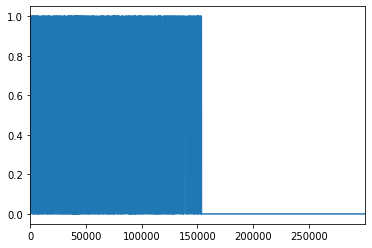

In [38]:
_ = pd.Series(ociosidade_classifier).plot()

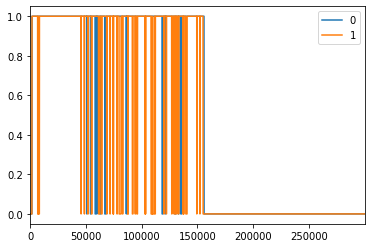

In [39]:
_ = pd.DataFrame(ociosidade_saborizador).plot()

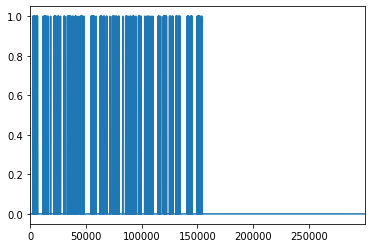

In [40]:
_ = pd.Series(ociosidade_embalador_Box).plot()

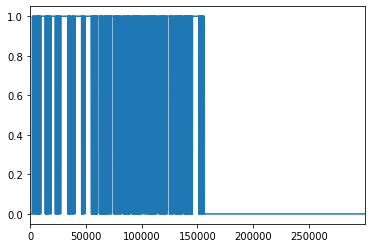

In [41]:
_ = pd.Series(ociosidade_embalador_Bag).plot()

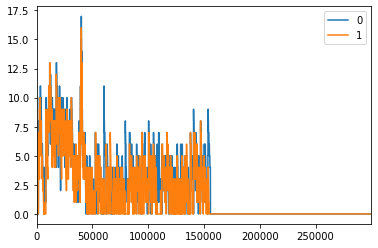

In [42]:
_ = pd.DataFrame(tamanho_da_fila_pfi).plot()

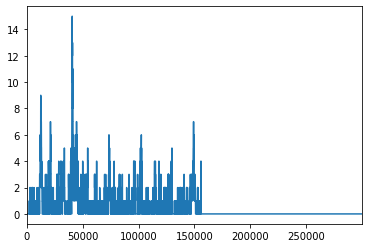

In [43]:
_ = pd.Series(tamanho_da_fila_bag).plot()

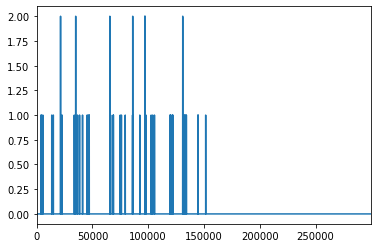

In [44]:
_ = pd.Series(tamanho_da_fila_box).plot()

In [45]:
teste2 = pd.DataFrame(classifier_balance, columns = ['Site', 'Color', 'Qty'])
teste2

,Site,Color,Qty
0,"Green Bay, WI",Coloring Agent23,55667.000
1,"Green Bay, WI",Coloring Agent23,0.000
2,"Green Bay, WI",Coloring Agent23,0.000
3,"Green Bay, WI",Coloring Agent23,0.000
4,"Green Bay, WI",Coloring Agent23,0.000
...,...,...,...
1208,"Green Bay, WI",Coloring Agent37,0.000
1209,"Green Bay, WI",Coloring Agent37,1746.462
1210,"Green Bay, WI",Coloring Agent37,0.000
1211,"Green Bay, WI",Coloring Agent37,0.000


In [46]:
pd.DataFrame(workorder.groupby(['Color','Size','Flavor','Packaging Type']).sum()['Qty']).to_csv(factory+'_Team3234_InventoryBalance.csv',sep=';', decimal = ',')

In [47]:
pfi_drum_aux

,Capacity In pounds,Level,Cor,Size,Num
Drum Number,,,,,
PFI_Drum1,6500,0,,,0
PFI_Drum2,6500,0,,,1
PFI_Drum3,6500,0,,,2
PFI_Drum4,6500,0,,,3
PFI_Drum5,6500,0,,,4
PFI_Drum6,6500,0,,,5
PFI_Drum7,6500,401,Coloring Agent37,S4,6
PFI_Drum8,6500,391,Coloring Agent13,S2,7
PFI_Drum9,6500,0,,,8


In [48]:
pfi_eq_aux

,Sabor,Ocupado,Num,Ultimo_uso
PFI,,,,
PFI_1,F9,1,0,155794
PFI_2,F2,1,1,154565


In [49]:
fi_drum_aux

,Capacity,Level,Cor,Size,Flavor,Num
Drum Number,,,,,,
FI_Drum_1,5500,0,,,,0
FI_Drum_2,5500,0,,,,1
FI_Drum_3,5500,0,,,,2
FI_Drum_4,5500,0,,,,3
FI_Drum_5,5500,0,,,,4
FI_Drum_6,5500,0,,,,5
FI_Drum_7,5500,0,,,,6
FI_Drum_8,5500,0,,,,7
FI_Drum_9,5500,0,,,,8


In [50]:
#Predizer a falha em uma determinada cor:
#Para cada ordem, determinar o quanto será produzido dos 5 tamanhos, se ela necessitar de tamanho